In [1]:
# ============================================================================
# PROYECTO: PREDICCIÓN DE CÁNCER DE PULMÓN USANDO MACHINE LEARNING
# ============================================================================

# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Para carga de datos
from google.colab import files

# ============================================================================
# 2. LIBRERÍAS PARA PREPROCESAMIENTO
# ============================================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# ============================================================================
# 3. LIBRERÍAS PARA ALGORITMOS SUPERVISADOS
# ============================================================================

# 3.2.1 Árboles de Decisión
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree

# 3.2.2 Regresiones: Lineal y Logística
from sklearn.linear_model import LinearRegression, LogisticRegression

# 3.2.3 KNN (K-Nearest Neighbors)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# 3.2.4 Clasificadores Bayesianos
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# ============================================================================
# 4. LIBRERÍAS PARA ALGORITMOS NO SUPERVISADOS
# ============================================================================

# 3.3.1 y 3.3.2 Clustering (K-Means)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

# ============================================================================
# 5. LIBRERÍAS PARA EVALUACIÓN DE MODELOS
# ============================================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_curve, roc_auc_score, silhouette_score
)

# ============================================================================
# 6. CONFIGURACIÓN DE VISUALIZACIÓN
# ============================================================================
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Todas las librerías han sido importadas correctamente")


✓ Todas las librerías han sido importadas correctamente


In [2]:
# ============================================================================
# 7. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ============================================================================

# Opción 1: Cargar desde archivo local
# uploaded = files.upload()
# df = pd.read_csv(list(uploaded.keys())[0])

# Opción 2: Cargar directamente (asumiendo que ya tienes el archivo)
df = pd.read_csv('survey lung cancer.csv')

print("\n" + "="*80)
print("INFORMACIÓN DEL DATASET")
print("="*80)
print(f"\nDimensiones del dataset: {df.shape}")
print(f"Número de registros: {df.shape[0]}")
print(f"Número de características: {df.shape[1]}")

print("\n" + "-"*80)
print("Primeras 5 filas del dataset:")
print("-"*80)
print(df.head())

print("\n" + "-"*80)
print("Información general del dataset:")
print("-"*80)
print(df.info())

print("\n" + "-"*80)
print("Estadísticas descriptivas:")
print("-"*80)
print(df.describe())

print("\n" + "-"*80)
print("Valores nulos por columna:")
print("-"*80)
print(df.isnull().sum())

print("\n" + "-"*80)
print("Distribución de la variable objetivo (LUNG_CANCER):")
print("-"*80)
print(df['LUNG_CANCER'].value_counts())



INFORMACIÓN DEL DATASET

Dimensiones del dataset: (309, 16)
Número de registros: 309
Número de características: 16

--------------------------------------------------------------------------------
Primeras 5 filas del dataset:
--------------------------------------------------------------------------------
  GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   69        1               2        2              1   
1      M   74        2               1        1              1   
2      F   59        1               1        1              2   
3      M   63        2               2        2              1   
4      F   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2   

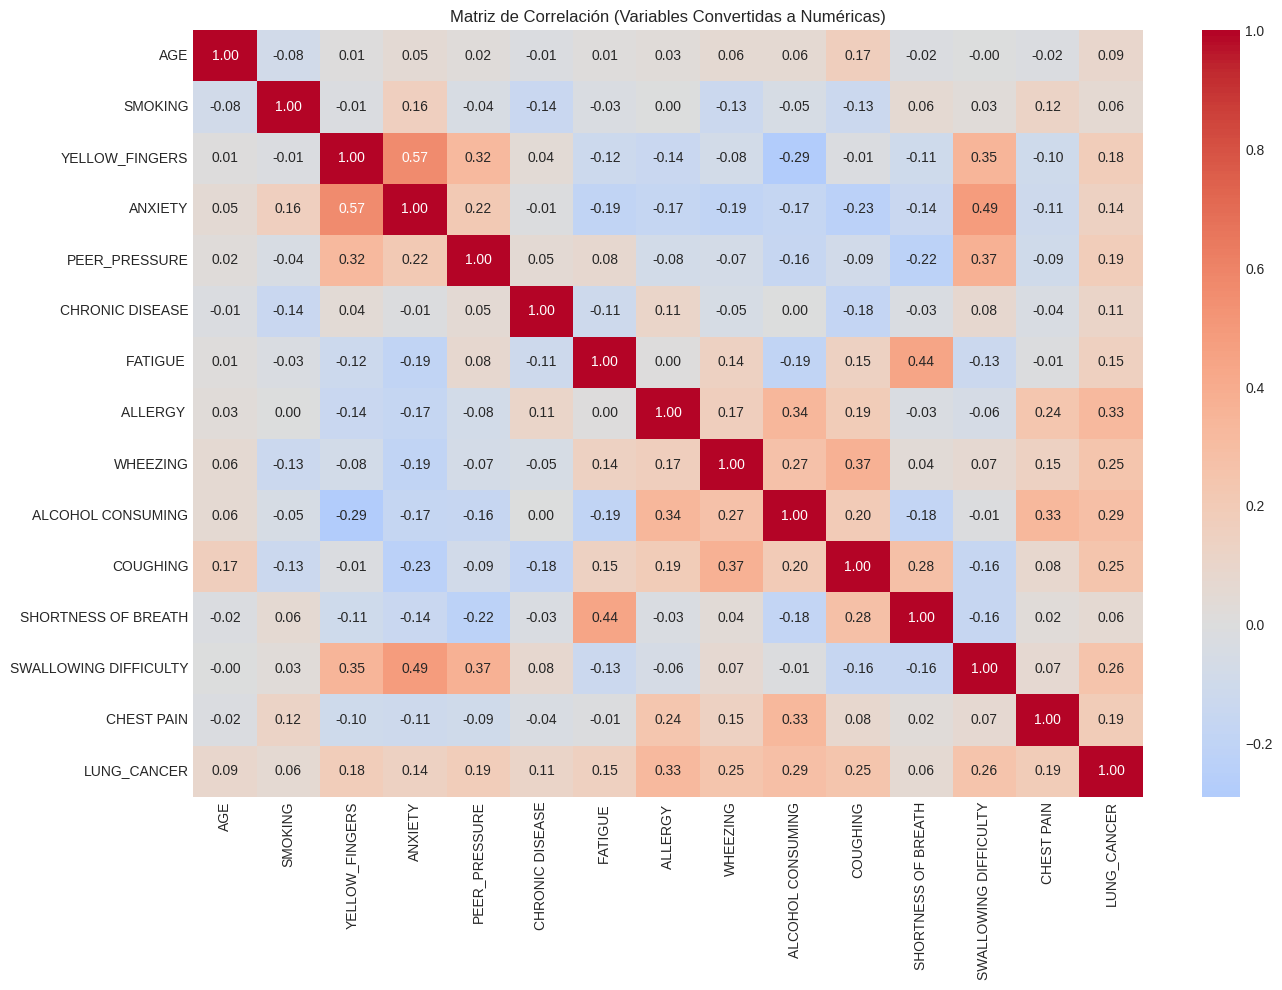


Correlaciones con LUNG_CANCER:
LUNG_CANCER              1.000000
ALLERGY                  0.327766
ALCOHOL CONSUMING        0.288533
SWALLOWING DIFFICULTY    0.259730
WHEEZING                 0.249300
COUGHING                 0.248570
CHEST PAIN               0.190451
PEER_PRESSURE            0.186388
YELLOW_FINGERS           0.181339
FATIGUE                  0.150673
ANXIETY                  0.144947
CHRONIC DISEASE          0.110891
AGE                      0.089465
SHORTNESS OF BREATH      0.060738
SMOKING                  0.058179
Name: LUNG_CANCER, dtype: float64


In [5]:
# ============================================================================
# 8. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ============================================================================

# ... (tu código de visualización inicial se mantiene igual) ...

# Matriz de correlación - CON CONVERSIÓN DE VARIABLE OBJETIVO
plt.figure(figsize=(14, 10))

# Crear copia del DataFrame y convertir variables categóricas importantes
df_for_corr = df.copy()

# Convertir LUNG_CANCER a numérico si es categórico
if df_for_corr['LUNG_CANCER'].dtype == 'object':
    # Convertir a valores numéricos (ej: YES=1, NO=0)
    df_for_corr['LUNG_CANCER'] = df_for_corr['LUNG_CANCER'].map({'YES': 1, 'NO': 0})

# También convertir otras columnas categóricas comunes
categorical_cols = ['GENDER']  # Añade otras columnas categóricas aquí
for col in categorical_cols:
    if col in df_for_corr.columns and df_for_corr[col].dtype == 'object':
        df_for_corr[col] = pd.get_dummies(df_for_corr[col], drop_first=True)

# Calcular correlación solo con columnas numéricas
correlation_matrix = df_for_corr.select_dtypes(include=['number']).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación (Variables Convertidas a Numéricas)')
plt.tight_layout()
plt.show()

# Mostrar correlaciones con LUNG_CANCER específicamente
if 'LUNG_CANCER' in correlation_matrix.columns:
    print("\nCorrelaciones con LUNG_CANCER:")
    lung_cancer_corr = correlation_matrix['LUNG_CANCER'].sort_values(ascending=False)
    print(lung_cancer_corr)

In [8]:
# ============================================================================
# 9. PREPROCESAMIENTO DE DATOS
# ============================================================================

print("\n" + "="*80)
print("PREPROCESAMIENTO DE DATOS")
print("="*80)

# Separar características (X) y variable objetivo (y)
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']

# Codificar variables categóricas si es necesario
# (En este caso, GENDER podría ser 'M'/'F')
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
    print(f"Columna '{column}' codificada")

# Codificar variable objetivo si es necesaria (YES/NO)
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print(f"Variable objetivo codificada: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDatos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Datos escalados correctamente")


PREPROCESAMIENTO DE DATOS
Columna 'GENDER' codificada
Variable objetivo codificada: {'NO': np.int64(0), 'YES': np.int64(1)}

Datos de entrenamiento: (247, 15)
Datos de prueba: (62, 15)

✓ Datos escalados correctamente



3.2.2. REGRESIÓN LINEAL

--------------------------------------------------------------------------------
RESULTADOS DE REGRESIÓN LINEAL
--------------------------------------------------------------------------------

Métricas de Regresión:
Error Cuadrático Medio (MSE): 0.0727
Raíz del Error Cuadrático Medio (RMSE): 0.2695
Error Absoluto Medio (MAE): 0.2016
Coeficiente de Determinación (R²): 0.3535

Métricas de Clasificación (con umbral 0.5):
Exactitud (Accuracy): 0.9032
Precisión (Precision): 0.9286
Sensibilidad (Recall): 0.9630
F1-Score: 0.9455

Matriz de Confusión:
[[ 4  4]
 [ 2 52]]


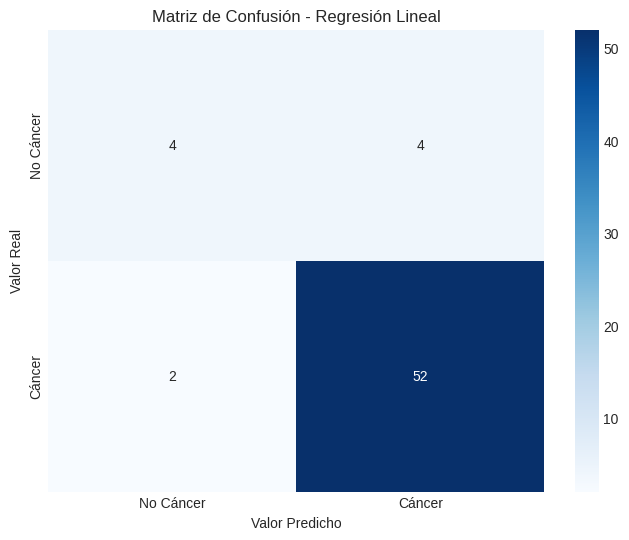


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Cáncer       0.67      0.50      0.57         8
      Cáncer       0.93      0.96      0.95        54

    accuracy                           0.90        62
   macro avg       0.80      0.73      0.76        62
weighted avg       0.89      0.90      0.90        62



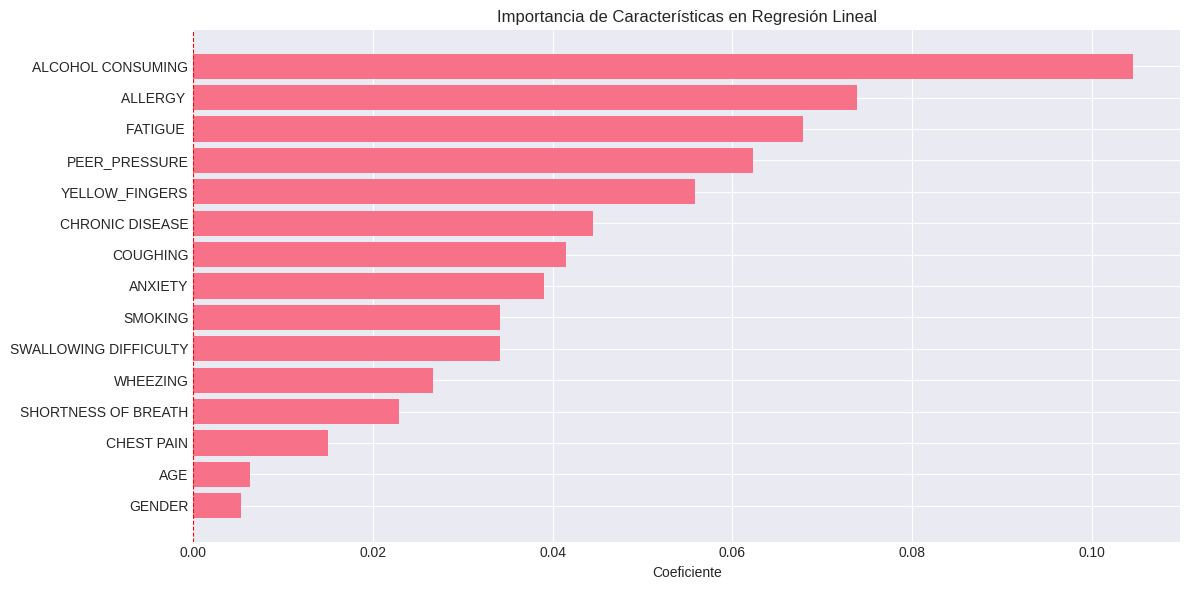

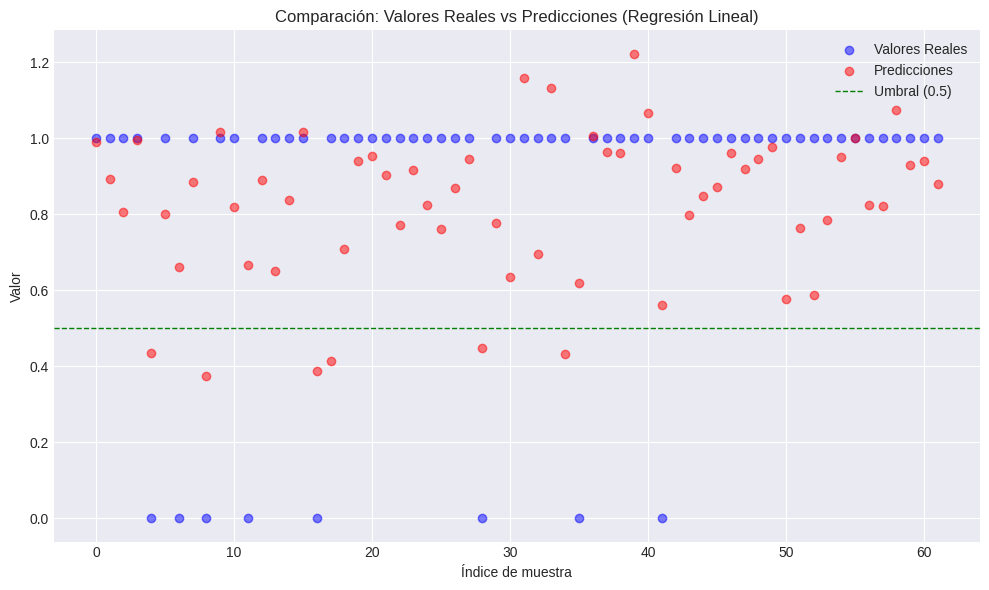


✓ ANÁLISIS DE REGRESIÓN LINEAL COMPLETADO


In [9]:
# ============================================================================
# 10. REGRESIÓN LINEAL
# ============================================================================

print("\n" + "="*80)
print("3.2.2. REGRESIÓN LINEAL")
print("="*80)

# Nota: La regresión lineal se usa típicamente para predecir valores continuos
# En este caso, como tenemos una variable binaria (0/1), la adaptamos
# para demostración, aunque Regresión Logística sería más apropiada

# Entrenar modelo de Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test_scaled)

# Convertir predicciones a valores binarios (0 o 1)
# Usamos 0.5 como umbral
y_pred_lr_binary = (y_pred_lr >= 0.5).astype(int)

print("\n" + "-"*80)
print("RESULTADOS DE REGRESIÓN LINEAL")
print("-"*80)

# Métricas para regresión
print("\nMétricas de Regresión:")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, y_pred_lr):.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, y_pred_lr):.4f}")
print(f"Coeficiente de Determinación (R²): {r2_score(y_test, y_pred_lr):.4f}")

# Métricas de clasificación (usando predicciones binarias)
print("\nMétricas de Clasificación (con umbral 0.5):")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_lr_binary):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred_lr_binary):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred_lr_binary):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr_binary):.4f}")

# Matriz de confusión
print("\nMatriz de Confusión:")
cm_lr = confusion_matrix(y_test, y_pred_lr_binary)
print(cm_lr)

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cáncer', 'Cáncer'],
            yticklabels=['No Cáncer', 'Cáncer'])
plt.title('Matriz de Confusión - Regresión Lineal')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_lr_binary,
                          target_names=['No Cáncer', 'Cáncer']))

# Visualización de coeficientes
plt.figure(figsize=(12, 6))
coef_df = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': lr_model.coef_
})
coef_df = coef_df.sort_values('Coeficiente', ascending=True)

plt.barh(coef_df['Característica'], coef_df['Coeficiente'])
plt.xlabel('Coeficiente')
plt.title('Importancia de Características en Regresión Lineal')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# Visualización de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, alpha=0.5, label='Valores Reales', color='blue')
plt.scatter(range(len(y_pred_lr)), y_pred_lr, alpha=0.5, label='Predicciones', color='red')
plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1, label='Umbral (0.5)')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Comparación: Valores Reales vs Predicciones (Regresión Lineal)')
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ ANÁLISIS DE REGRESIÓN LINEAL COMPLETADO")
print("="*80)

In [10]:
# ============================================================================
# 11. ÁRBOLES DE DECISIÓN
# ============================================================================

print("\n" + "="*80)
print("3.2.1. ÁRBOLES DE DECISIÓN")
print("="*80)


3.2.1. ÁRBOLES DE DECISIÓN



--------------------------------------------------------------------------------
ÁRBOL DE DECISIÓN - CLASIFICACIÓN
--------------------------------------------------------------------------------

Métricas de Clasificación:
Exactitud (Accuracy): 0.8548
Precisión (Precision): 0.9091
Sensibilidad (Recall): 0.9259
F1-Score: 0.9174
AUC-ROC: 0.8669

Matriz de Confusión:
[[ 3  5]
 [ 4 50]]


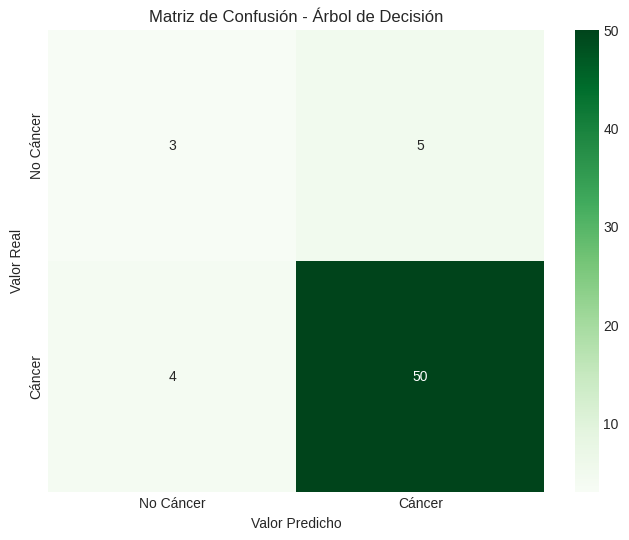


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

   No Cáncer       0.43      0.38      0.40         8
      Cáncer       0.91      0.93      0.92        54

    accuracy                           0.85        62
   macro avg       0.67      0.65      0.66        62
weighted avg       0.85      0.85      0.85        62



In [11]:
# ============================================================================
# 11.1. Árbol de Decisión para Clasificación
# ============================================================================

print("\n" + "-"*80)
print("ÁRBOL DE DECISIÓN - CLASIFICACIÓN")
print("-"*80)

# Entrenar modelo de Árbol de Decisión
dt_classifier = DecisionTreeClassifier(
    max_depth=5,  # Profundidad máxima del árbol
    min_samples_split=10,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf=5,  # Mínimo de muestras en una hoja
    random_state=42,
    criterion='gini'  # Puede ser 'gini' o 'entropy'
)

dt_classifier.fit(X_train, y_train)

# Predicciones
y_pred_dt = dt_classifier.predict(X_test)
y_pred_proba_dt = dt_classifier.predict_proba(X_test)[:, 1]

# Evaluación del modelo
print("\nMétricas de Clasificación:")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred_dt):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):.4f}")

# AUC-ROC
try:
    auc_score = roc_auc_score(y_test, y_pred_proba_dt)
    print(f"AUC-ROC: {auc_score:.4f}")
except:
    print("AUC-ROC: No se pudo calcular")

# Matriz de confusión
print("\nMatriz de Confusión:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Cáncer', 'Cáncer'],
            yticklabels=['No Cáncer', 'Cáncer'])
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Reporte de clasificación detallado
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_dt,
                          target_names=['No Cáncer', 'Cáncer']))



--------------------------------------------------------------------------------
IMPORTANCIA DE CARACTERÍSTICAS
--------------------------------------------------------------------------------

Importancia de cada característica:
           Característica  Importancia
10      ALCOHOL CONSUMING     0.221999
8                ALLERGY      0.221694
13  SWALLOWING DIFFICULTY     0.198449
5           PEER_PRESSURE     0.159366
7                FATIGUE      0.067456
1                     AGE     0.065137
4                 ANXIETY     0.045728
6         CHRONIC DISEASE     0.012804
3          YELLOW_FINGERS     0.007367
0                  GENDER     0.000000
2                 SMOKING     0.000000
9                WHEEZING     0.000000
11               COUGHING     0.000000
12    SHORTNESS OF BREATH     0.000000
14             CHEST PAIN     0.000000


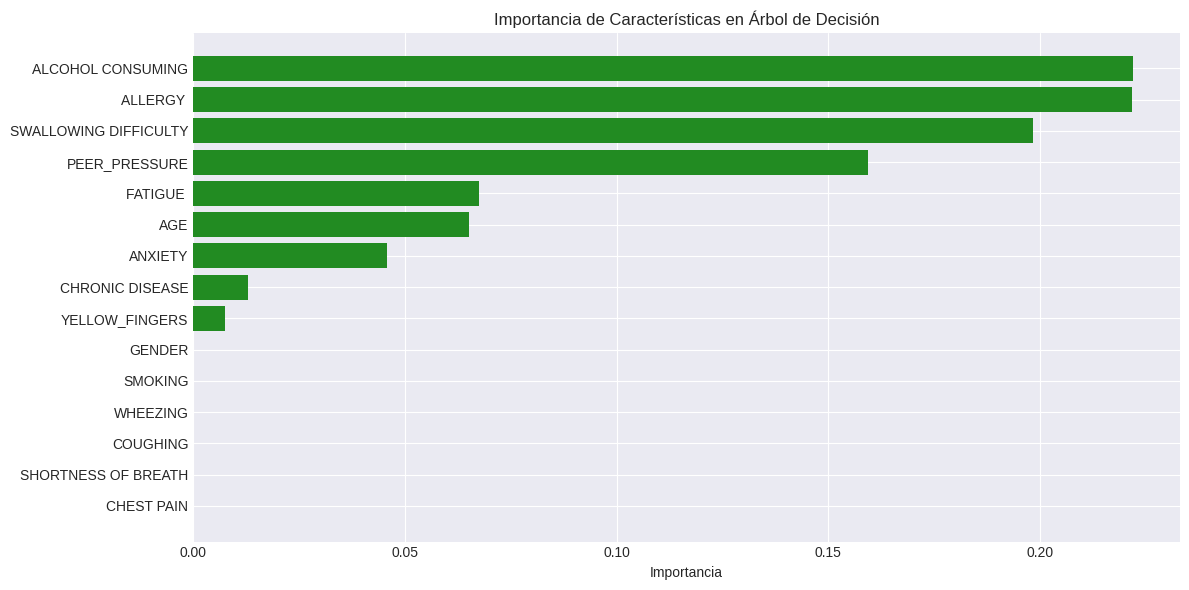

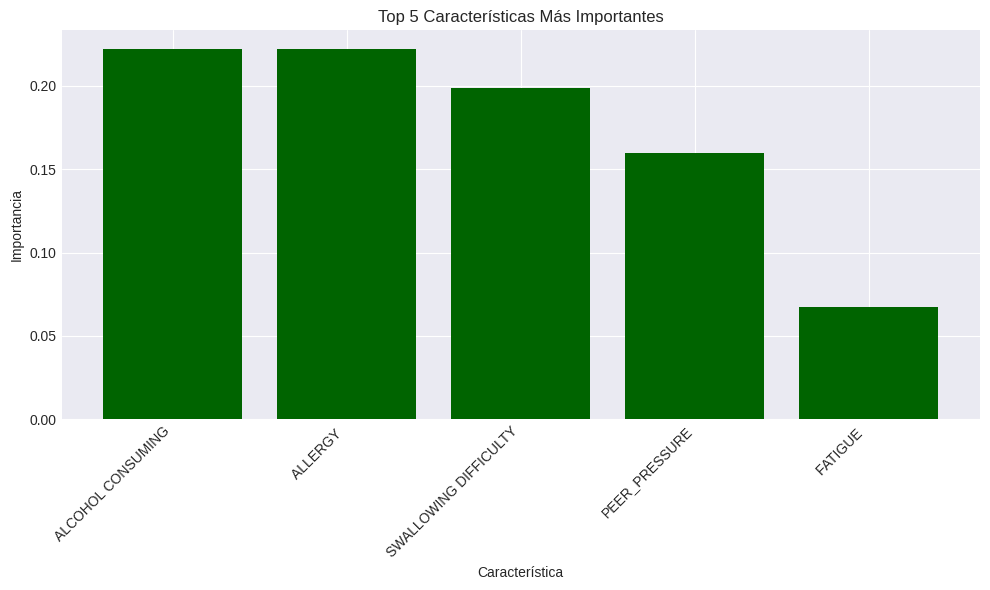

In [12]:
# ============================================================================
# 11.2. Importancia de Características
# ============================================================================

print("\n" + "-"*80)
print("IMPORTANCIA DE CARACTERÍSTICAS")
print("-"*80)

# Obtener importancia de características
feature_importance = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': dt_classifier.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nImportancia de cada característica:")
print(feature_importance)

# Visualización de importancia de características
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Característica'], feature_importance['Importancia'], color='forestgreen')
plt.xlabel('Importancia')
plt.title('Importancia de Características en Árbol de Decisión')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Top 5 características más importantes
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(5)
plt.bar(top_features['Característica'], top_features['Importancia'], color='darkgreen')
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.title('Top 5 Características Más Importantes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



--------------------------------------------------------------------------------
VISUALIZACIÓN DEL ÁRBOL
--------------------------------------------------------------------------------


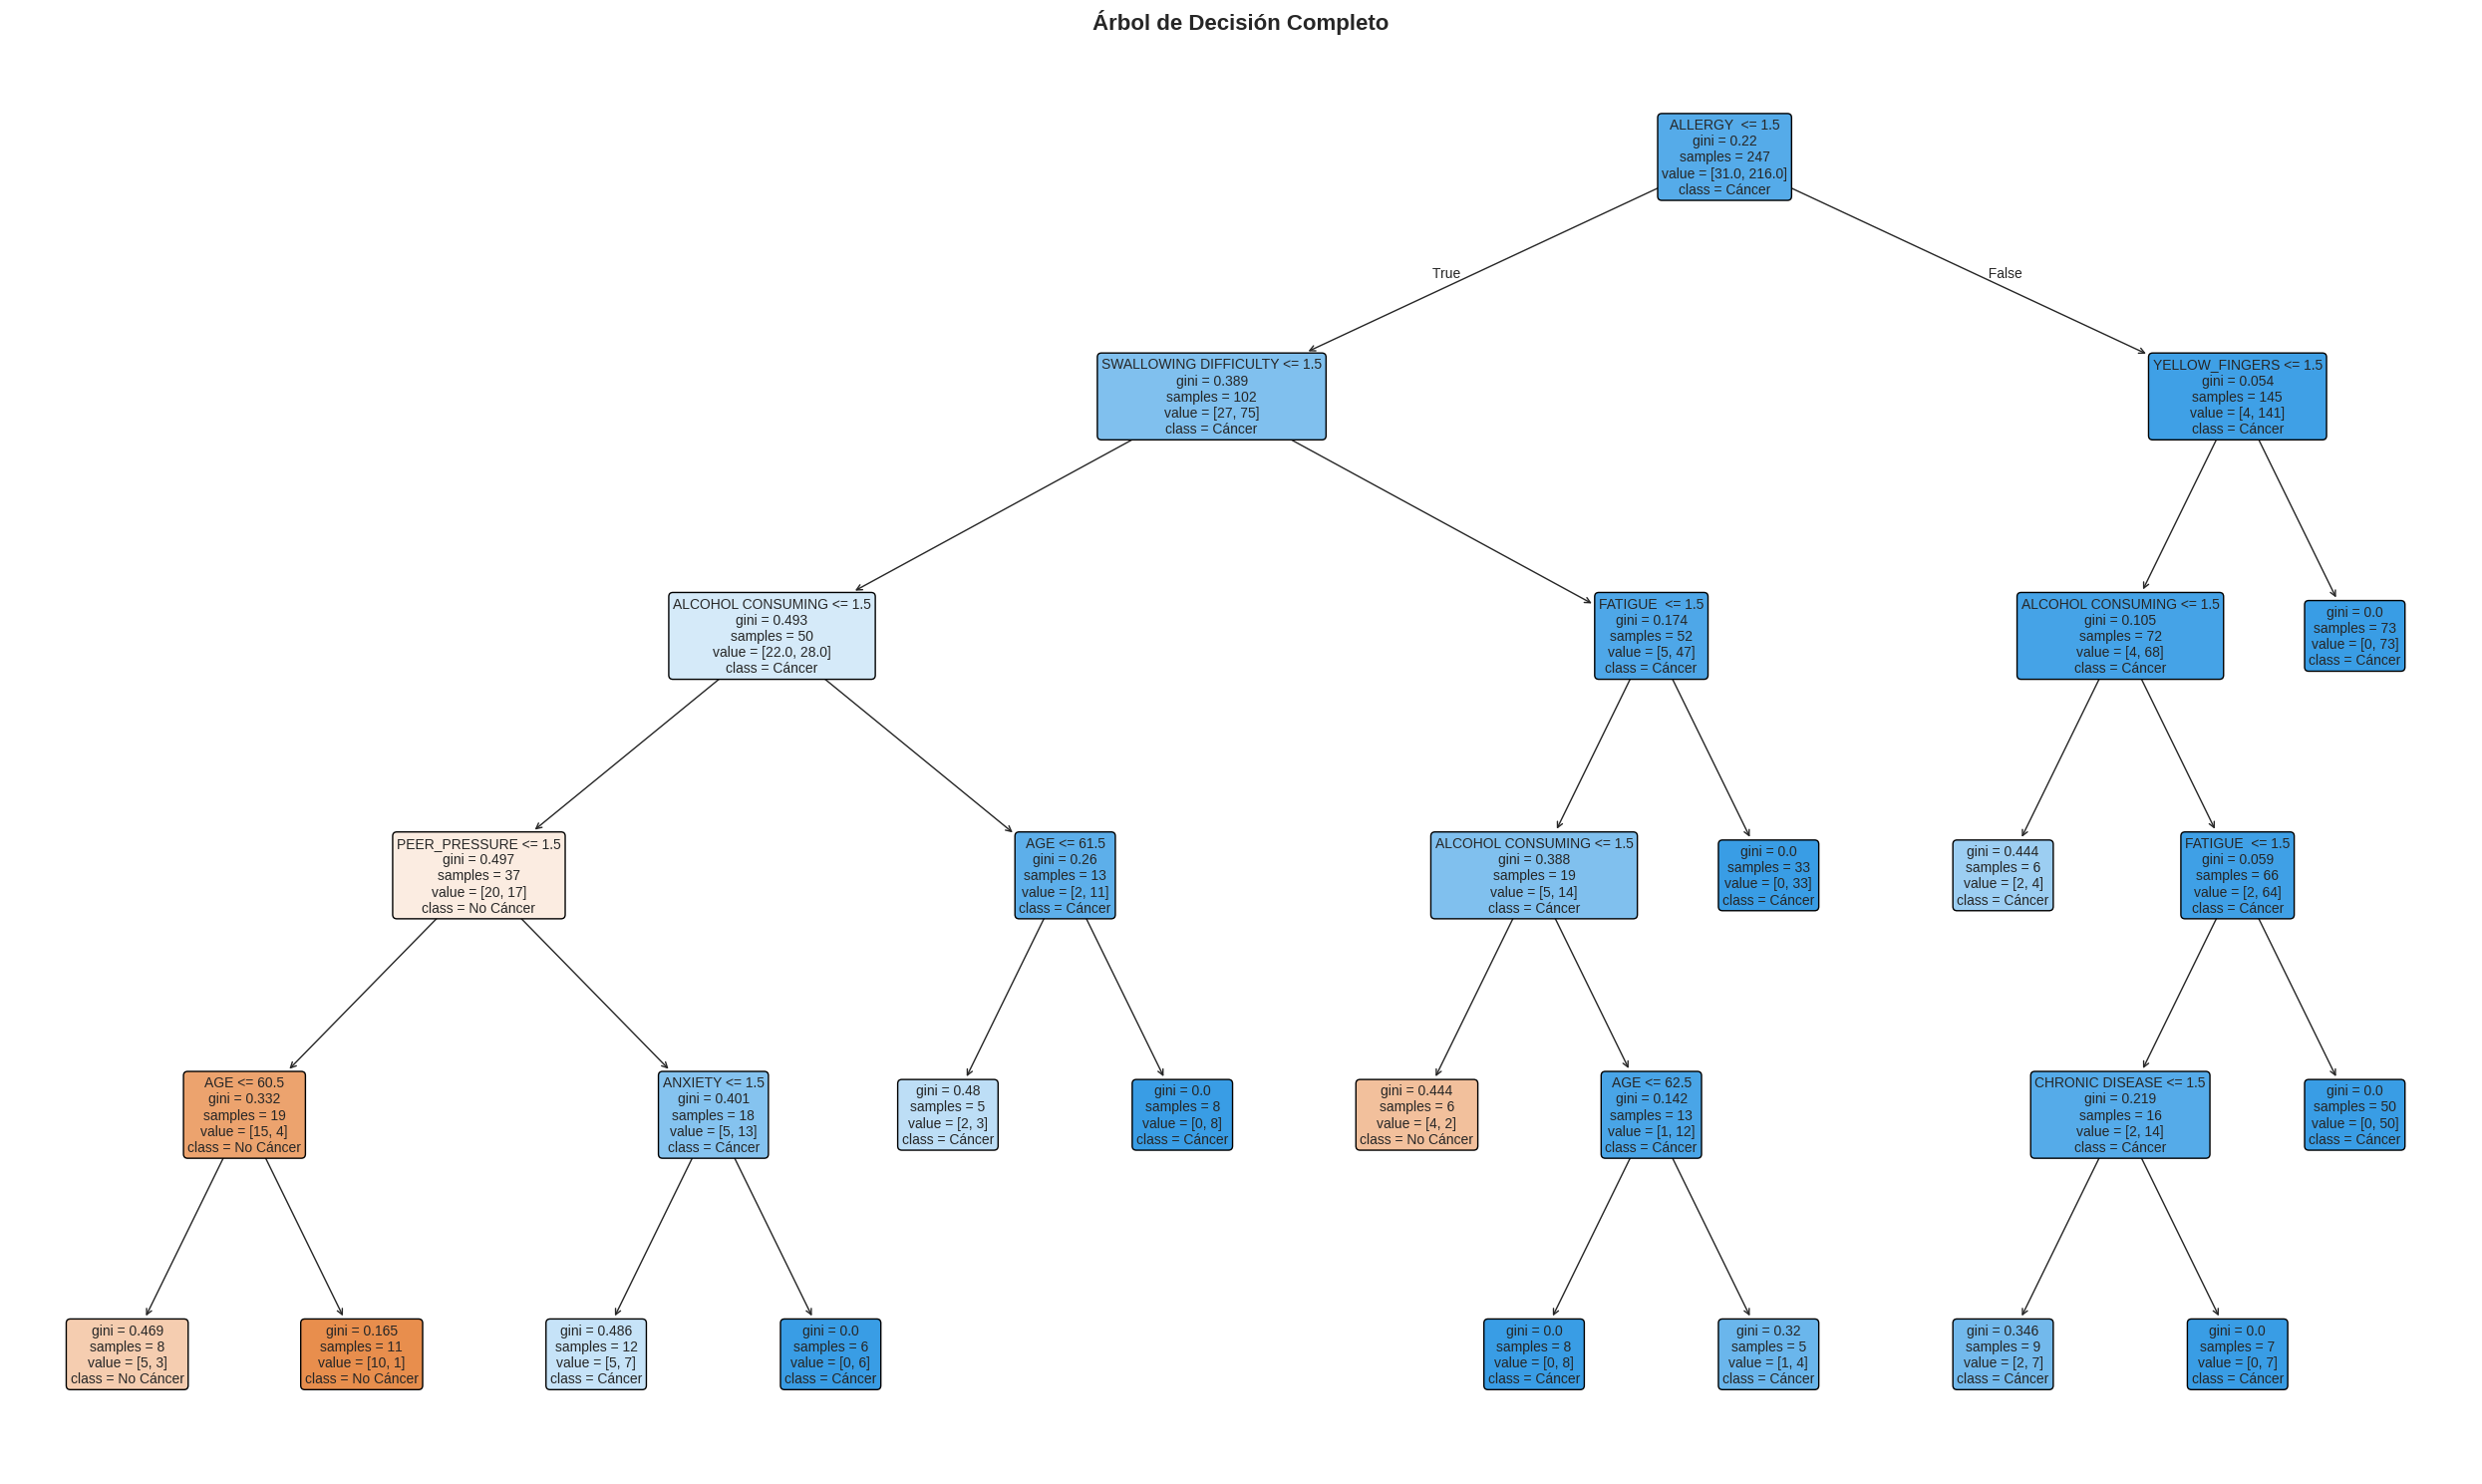

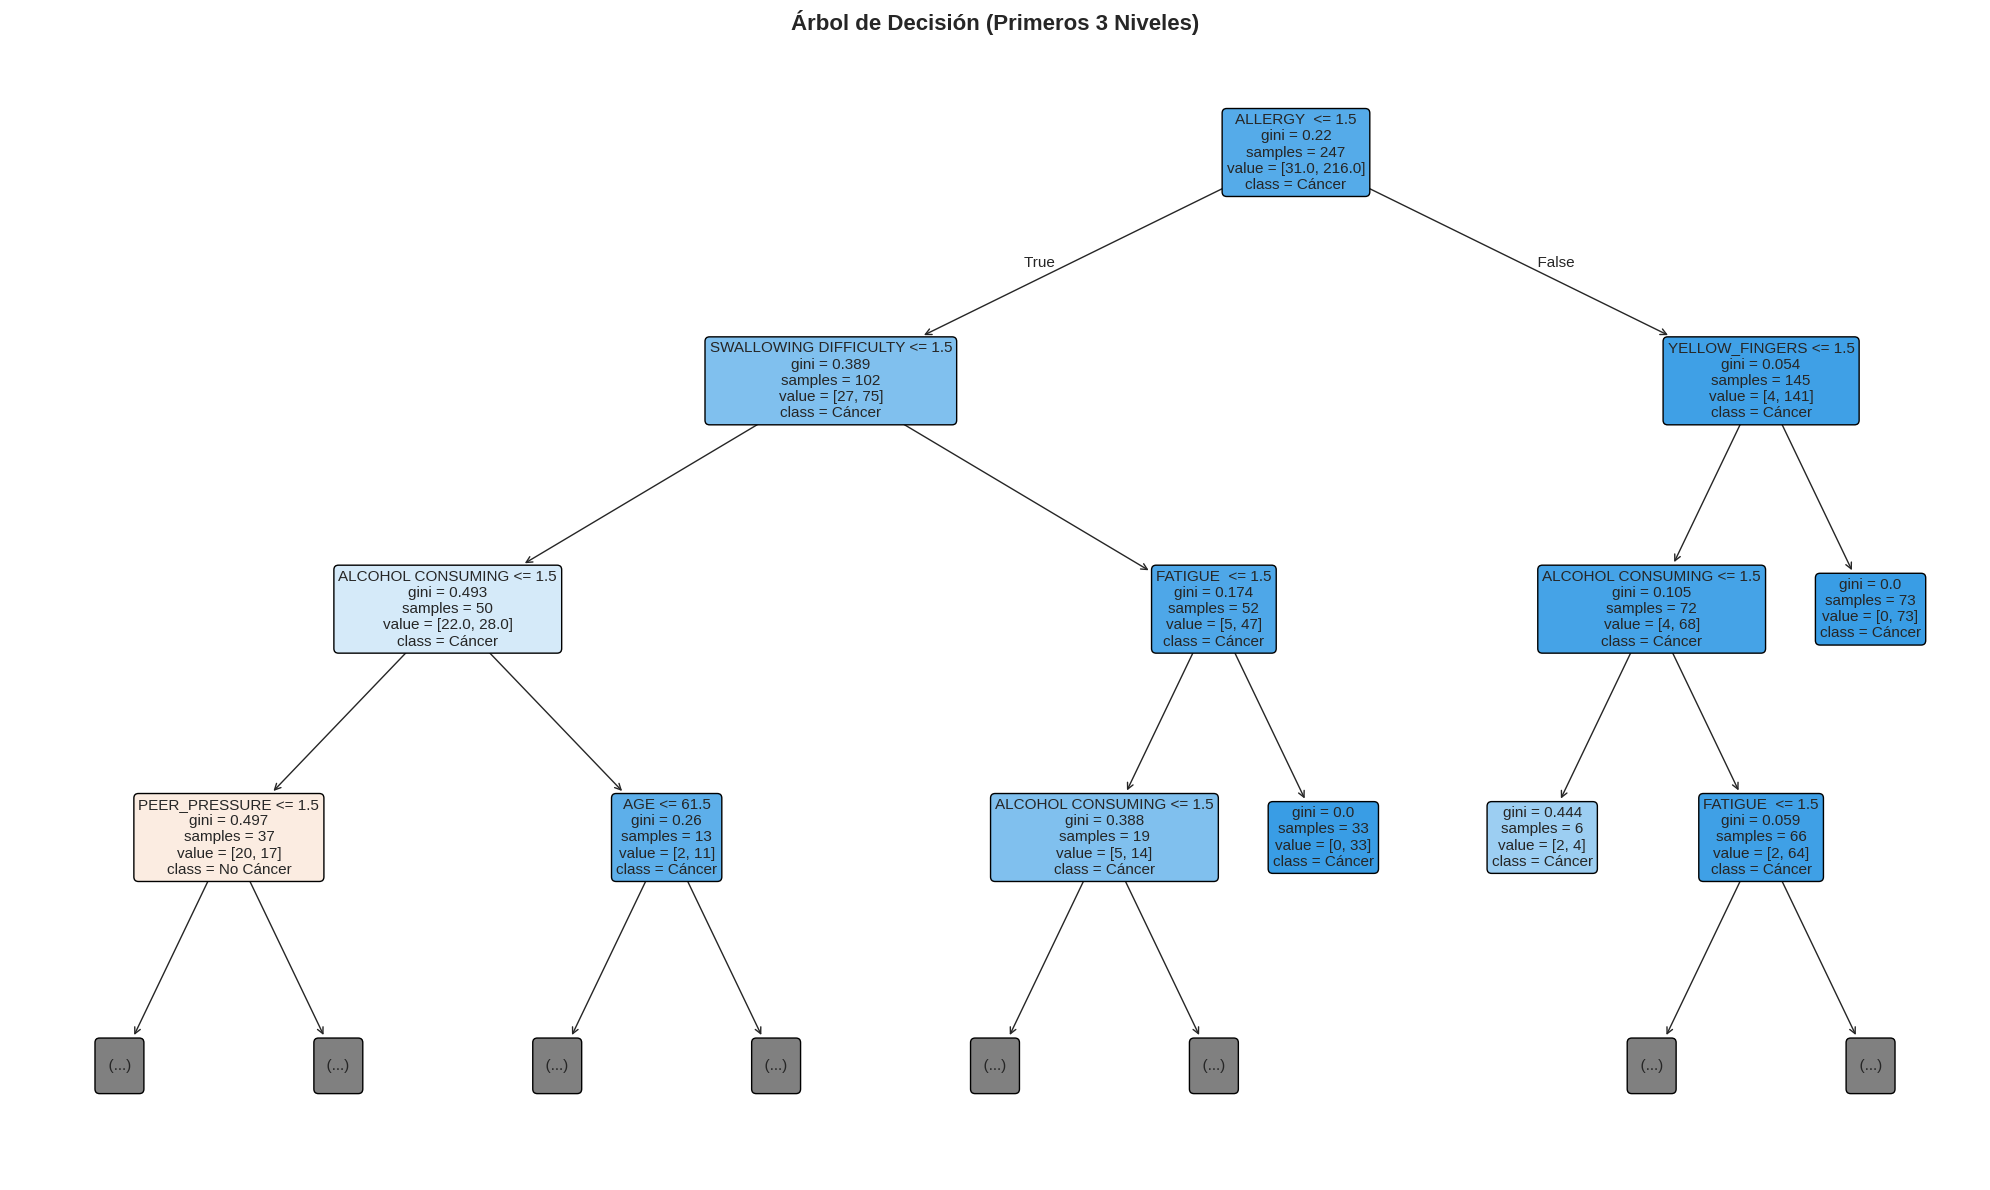

In [13]:
# ============================================================================
# 11.3. Visualización del Árbol de Decisión
# ============================================================================

print("\n" + "-"*80)
print("VISUALIZACIÓN DEL ÁRBOL")
print("-"*80)

# Visualización completa del árbol
plt.figure(figsize=(25, 15))
plot_tree(dt_classifier,
          feature_names=X.columns,
          class_names=['No Cáncer', 'Cáncer'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Árbol de Decisión Completo', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualización simplificada (primeros niveles)
plt.figure(figsize=(20, 12))
plot_tree(dt_classifier,
          feature_names=X.columns,
          class_names=['No Cáncer', 'Cáncer'],
          filled=True,
          rounded=True,
          fontsize=11,
          max_depth=3)  # Solo mostrar 3 niveles
plt.title('Árbol de Decisión (Primeros 3 Niveles)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
CURVA ROC
--------------------------------------------------------------------------------


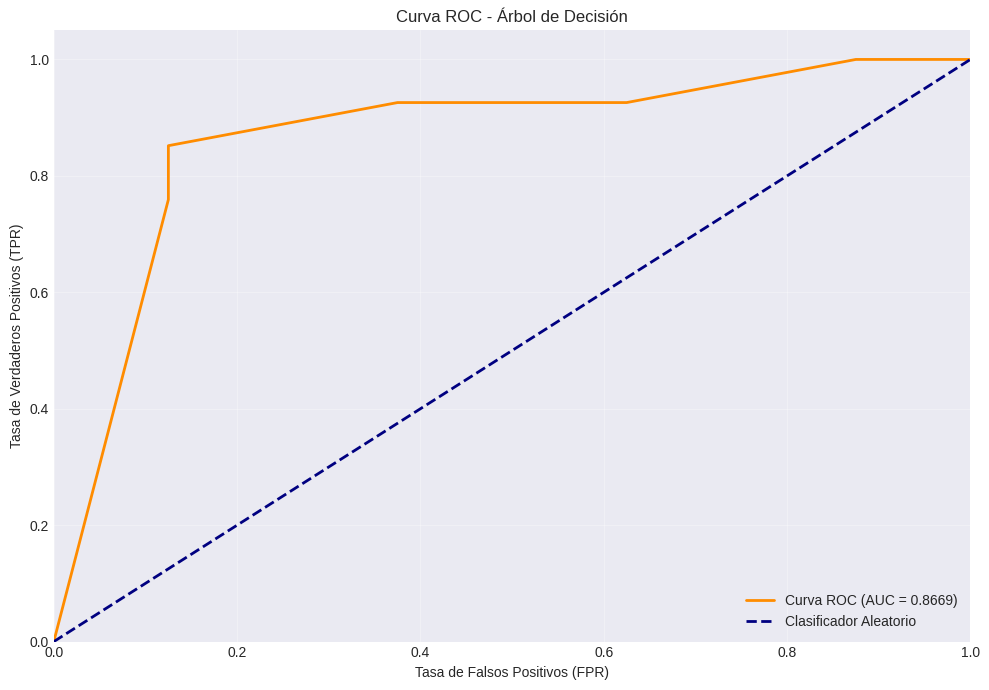

In [14]:
# ============================================================================
# 11.4. Curva ROC
# ============================================================================

print("\n" + "-"*80)
print("CURVA ROC")
print("-"*80)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = roc_auc_score(y_test, y_pred_proba_dt)

# Visualizar la curva ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
VALIDACIÓN CRUZADA
--------------------------------------------------------------------------------

Puntajes de Validación Cruzada (5-fold):
Fold 1: 0.9200
Fold 2: 0.8400
Fold 3: 0.8980
Fold 4: 0.8980
Fold 5: 0.9184

Promedio de Accuracy: 0.8949
Desviación Estándar: 0.0290


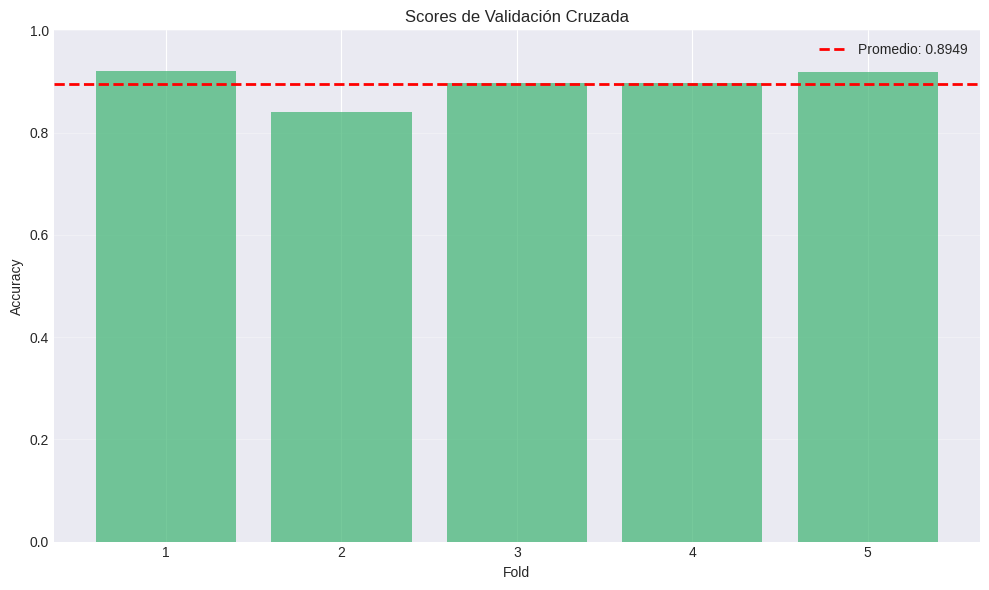

In [15]:
# ============================================================================
# 11.5. Validación Cruzada
# ============================================================================

print("\n" + "-"*80)
print("VALIDACIÓN CRUZADA")
print("-"*80)

# Realizar validación cruzada con 5 folds
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')

print(f"\nPuntajes de Validación Cruzada (5-fold):")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nPromedio de Accuracy: {cv_scores.mean():.4f}")
print(f"Desviación Estándar: {cv_scores.std():.4f}")

# Visualización de scores de validación cruzada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='mediumseagreen', alpha=0.7)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--',
            linewidth=2, label=f'Promedio: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Scores de Validación Cruzada')
plt.legend()
plt.ylim([0, 1])
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [16]:
# ============================================================================
# 11.6. Optimización de Hiperparámetros (GridSearchCV)
# ============================================================================

print("\n" + "-"*80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("-"*80)

# Definir grid de parámetros a probar
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nBuscando mejores hiperparámetros...")
grid_search.fit(X_train, y_train)

print(f"\nMejores parámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor score de validación cruzada: {grid_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)

print(f"\nAccuracy en conjunto de prueba (modelo optimizado): {accuracy_score(y_test, y_pred_best):.4f}")


--------------------------------------------------------------------------------
OPTIMIZACIÓN DE HIPERPARÁMETROS
--------------------------------------------------------------------------------

Buscando mejores hiperparámetros...
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Mejores parámetros encontrados:
  criterion: gini
  max_depth: 5
  min_samples_leaf: 5
  min_samples_split: 20

Mejor score de validación cruzada: 0.9029

Accuracy en conjunto de prueba (modelo optimizado): 0.8548



--------------------------------------------------------------------------------
ANÁLISIS DE PROFUNDIDAD DEL ÁRBOL
--------------------------------------------------------------------------------


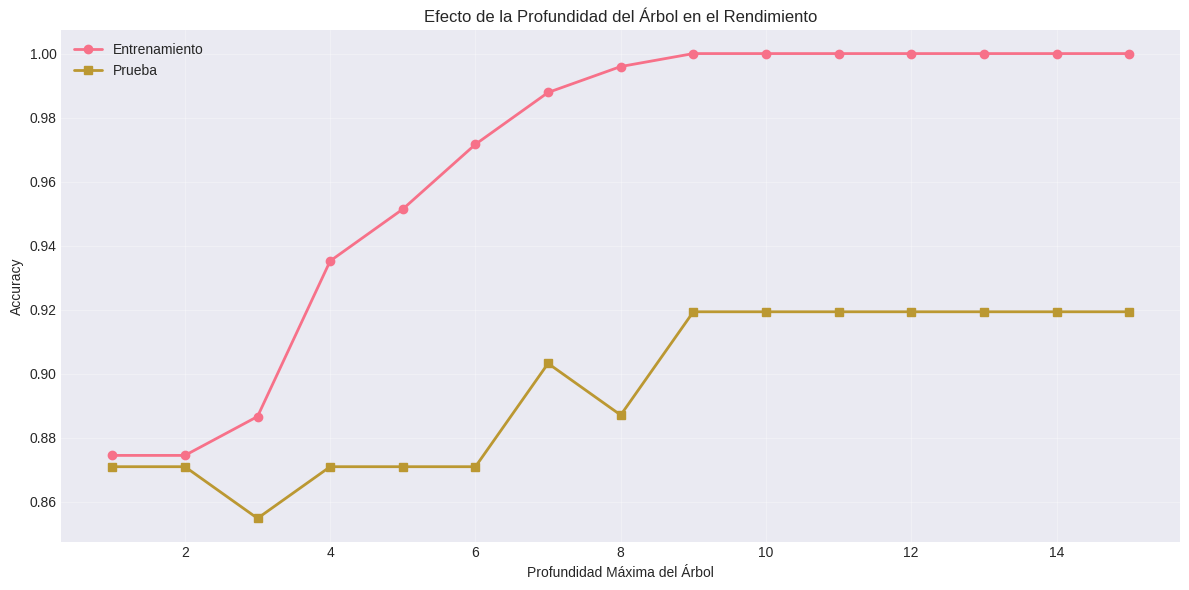


Profundidad óptima: 9
Accuracy en entrenamiento: 1.0000
Accuracy en prueba: 0.9194


In [17]:
# ============================================================================
# 11.7. Comparación de Profundidades
# ============================================================================

print("\n" + "-"*80)
print("ANÁLISIS DE PROFUNDIDAD DEL ÁRBOL")
print("-"*80)

# Probar diferentes profundidades
depths = range(1, 16)
train_scores = []
test_scores = []

for depth in depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)

    train_scores.append(dt_temp.score(X_train, y_train))
    test_scores.append(dt_temp.score(X_test, y_test))

# Visualización del efecto de la profundidad
plt.figure(figsize=(12, 6))
plt.plot(depths, train_scores, marker='o', label='Entrenamiento', linewidth=2)
plt.plot(depths, test_scores, marker='s', label='Prueba', linewidth=2)
plt.xlabel('Profundidad Máxima del Árbol')
plt.ylabel('Accuracy')
plt.title('Efecto de la Profundidad del Árbol en el Rendimiento')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Encontrar la profundidad óptima
optimal_depth = depths[np.argmax(test_scores)]
print(f"\nProfundidad óptima: {optimal_depth}")
print(f"Accuracy en entrenamiento: {max(train_scores):.4f}")
print(f"Accuracy en prueba: {max(test_scores):.4f}")

In [18]:
# ============================================================================
# 11.8. Información del Árbol
# ============================================================================

print("\n" + "-"*80)
print("INFORMACIÓN DEL ÁRBOL ENTRENADO")
print("-"*80)

print(f"\nProfundidad del árbol: {dt_classifier.get_depth()}")
print(f"Número de hojas: {dt_classifier.get_n_leaves()}")
print(f"Número de características usadas: {np.sum(dt_classifier.feature_importances_ > 0)}")

print("\n" + "="*80)
print("✓ ANÁLISIS DE ÁRBOLES DE DECISIÓN COMPLETADO")
print("="*80)


--------------------------------------------------------------------------------
INFORMACIÓN DEL ÁRBOL ENTRENADO
--------------------------------------------------------------------------------

Profundidad del árbol: 5
Número de hojas: 15
Número de características usadas: 9

✓ ANÁLISIS DE ÁRBOLES DE DECISIÓN COMPLETADO


In [19]:
# ============================================================================
# 12. ALGORITMO KNN (K-NEAREST NEIGHBORS)
# ============================================================================

print("\n" + "="*80)
print("3.2.3. ALGORITMO KNN (K-NEAREST NEIGHBORS)")
print("="*80)


3.2.3. ALGORITMO KNN (K-NEAREST NEIGHBORS)



--------------------------------------------------------------------------------
KNN - CLASIFICACIÓN
--------------------------------------------------------------------------------

Métricas de Clasificación (k=5):
Exactitud (Accuracy): 0.8710
Precisión (Precision): 0.9107
Sensibilidad (Recall): 0.9444
F1-Score: 0.9273
AUC-ROC: 0.8970

Matriz de Confusión:
[[ 3  5]
 [ 3 51]]


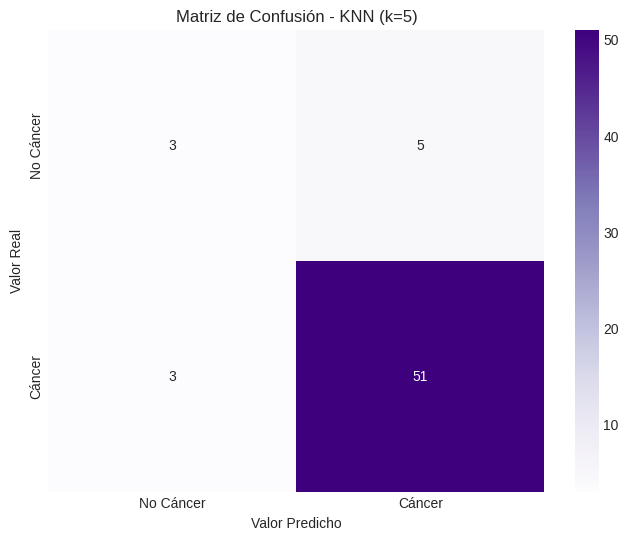


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

   No Cáncer       0.50      0.38      0.43         8
      Cáncer       0.91      0.94      0.93        54

    accuracy                           0.87        62
   macro avg       0.71      0.66      0.68        62
weighted avg       0.86      0.87      0.86        62



In [20]:
# ============================================================================
# 12.1. KNN para Clasificación
# ============================================================================

print("\n" + "-"*80)
print("KNN - CLASIFICACIÓN")
print("-"*80)

# Entrenar modelo KNN con k=5 (valor inicial)
knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',  # Puede ser 'uniform' o 'distance'
    algorithm='auto',
    metric='euclidean'
)

knn_classifier.fit(X_train_scaled, y_train)

# Predicciones
y_pred_knn = knn_classifier.predict(X_test_scaled)
y_pred_proba_knn = knn_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluación del modelo
print("\nMétricas de Clasificación (k=5):")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred_knn):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred_knn):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn):.4f}")

# AUC-ROC
try:
    auc_score_knn = roc_auc_score(y_test, y_pred_proba_knn)
    print(f"AUC-ROC: {auc_score_knn:.4f}")
except:
    print("AUC-ROC: No se pudo calcular")

# Matriz de confusión
print("\nMatriz de Confusión:")
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples',
            xticklabels=['No Cáncer', 'Cáncer'],
            yticklabels=['No Cáncer', 'Cáncer'])
plt.title('Matriz de Confusión - KNN (k=5)')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Reporte de clasificación detallado
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_knn,
                          target_names=['No Cáncer', 'Cáncer']))



--------------------------------------------------------------------------------
BÚSQUEDA DEL VALOR ÓPTIMO DE K
--------------------------------------------------------------------------------

Evaluando diferentes valores de k...

Mejor valor de k: 1
Mejor Accuracy en prueba: 0.8871


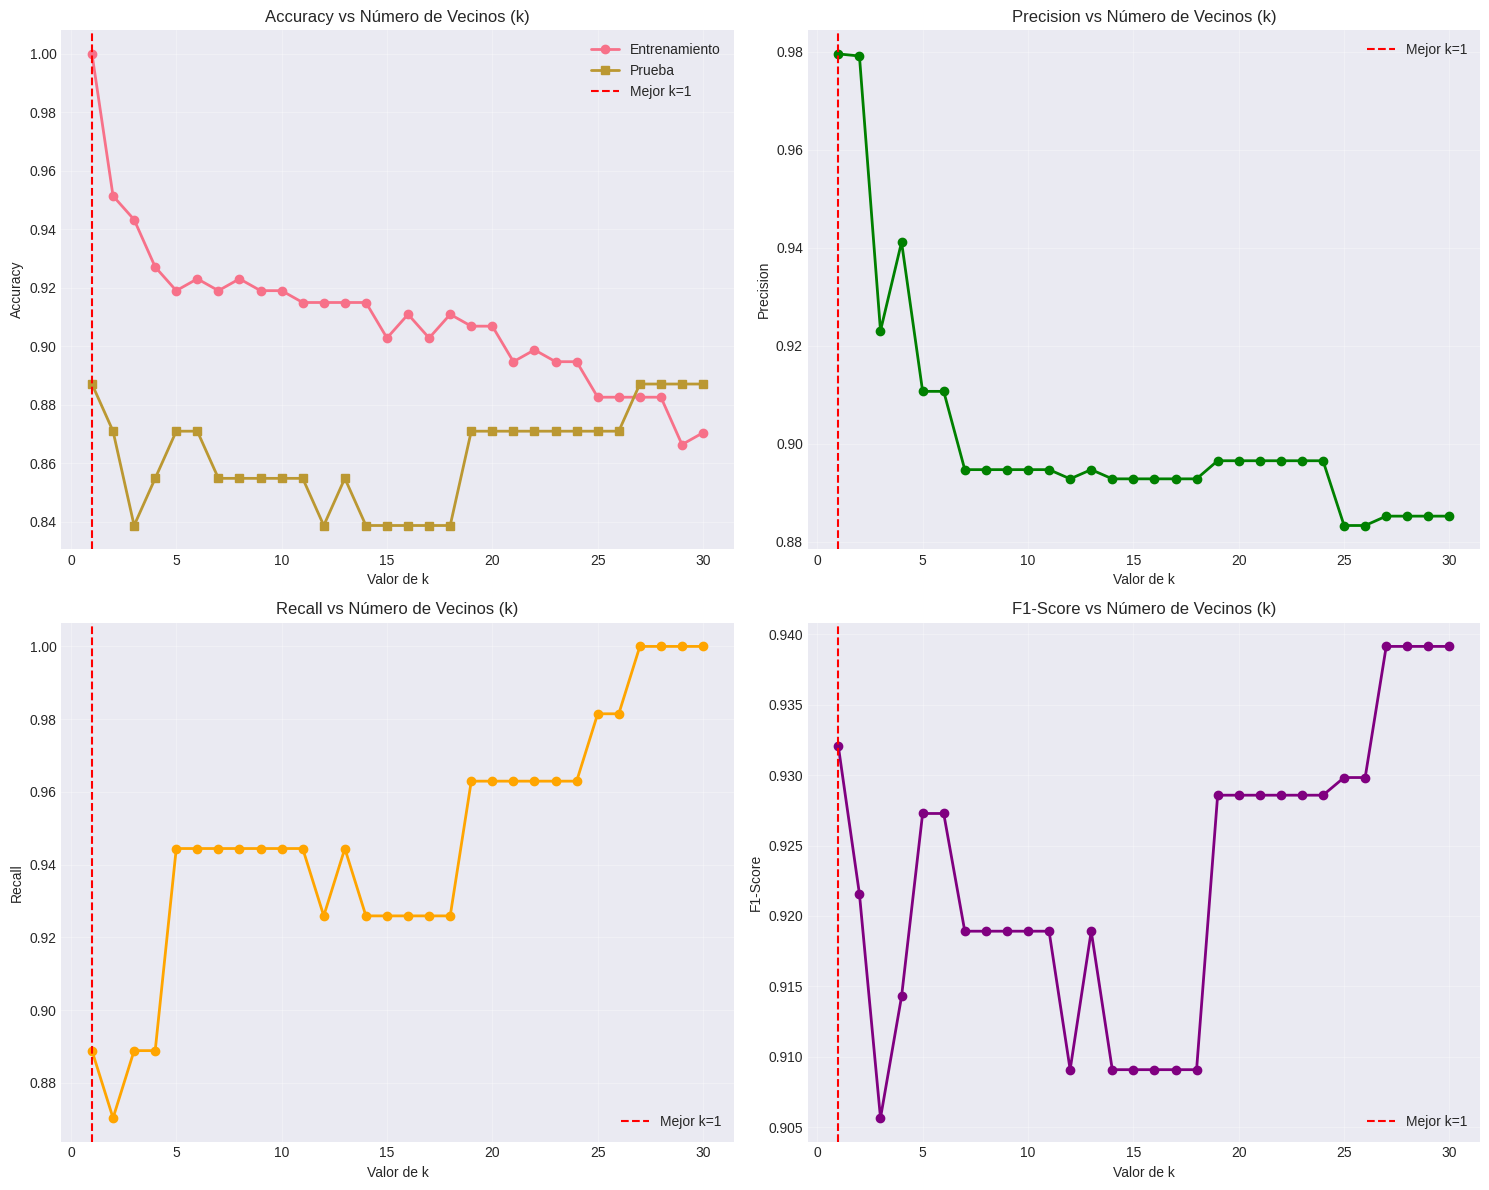

In [21]:
# ============================================================================
# 12.2. Búsqueda del Valor Óptimo de K
# ============================================================================

print("\n" + "-"*80)
print("BÚSQUEDA DEL VALOR ÓPTIMO DE K")
print("-"*80)

# Probar diferentes valores de k
k_values = range(1, 31)
train_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

print("\nEvaluando diferentes valores de k...")
for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_temp.fit(X_train_scaled, y_train)

    # Accuracy en entrenamiento y prueba
    train_accuracies.append(knn_temp.score(X_train_scaled, y_train))
    test_accuracies.append(knn_temp.score(X_test_scaled, y_test))

    # Otras métricas
    y_pred_temp = knn_temp.predict(X_test_scaled)
    precision_scores.append(precision_score(y_test, y_pred_temp))
    recall_scores.append(recall_score(y_test, y_pred_temp))
    f1_scores.append(f1_score(y_test, y_pred_temp))

# Encontrar el mejor k basado en accuracy de prueba
best_k = k_values[np.argmax(test_accuracies)]
best_accuracy = max(test_accuracies)

print(f"\nMejor valor de k: {best_k}")
print(f"Mejor Accuracy en prueba: {best_accuracy:.4f}")

# Visualización del efecto de k en el rendimiento
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Accuracy
axes[0, 0].plot(k_values, train_accuracies, marker='o', label='Entrenamiento', linewidth=2)
axes[0, 0].plot(k_values, test_accuracies, marker='s', label='Prueba', linewidth=2)
axes[0, 0].axvline(x=best_k, color='red', linestyle='--', label=f'Mejor k={best_k}')
axes[0, 0].set_xlabel('Valor de k')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Número de Vecinos (k)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Gráfico 2: Precision
axes[0, 1].plot(k_values, precision_scores, marker='o', color='green', linewidth=2)
axes[0, 1].axvline(x=best_k, color='red', linestyle='--', label=f'Mejor k={best_k}')
axes[0, 1].set_xlabel('Valor de k')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision vs Número de Vecinos (k)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Gráfico 3: Recall
axes[1, 0].plot(k_values, recall_scores, marker='o', color='orange', linewidth=2)
axes[1, 0].axvline(x=best_k, color='red', linestyle='--', label=f'Mejor k={best_k}')
axes[1, 0].set_xlabel('Valor de k')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall vs Número de Vecinos (k)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Gráfico 4: F1-Score
axes[1, 1].plot(k_values, f1_scores, marker='o', color='purple', linewidth=2)
axes[1, 1].axvline(x=best_k, color='red', linestyle='--', label=f'Mejor k={best_k}')
axes[1, 1].set_xlabel('Valor de k')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('F1-Score vs Número de Vecinos (k)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# ============================================================================
# 12.3. Modelo KNN Óptimo
# ============================================================================

print("\n" + "-"*80)
print("MODELO KNN ÓPTIMO")
print("-"*80)

# Entrenar con el mejor k encontrado
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights='uniform')
knn_best.fit(X_train_scaled, y_train)

# Predicciones con el mejor modelo
y_pred_knn_best = knn_best.predict(X_test_scaled)
y_pred_proba_knn_best = knn_best.predict_proba(X_test_scaled)[:, 1]

print(f"\nMétricas del Modelo Óptimo (k={best_k}):")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_knn_best):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred_knn_best):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred_knn_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn_best):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_knn_best):.4f}")


--------------------------------------------------------------------------------
MODELO KNN ÓPTIMO
--------------------------------------------------------------------------------

Métricas del Modelo Óptimo (k=1):
Exactitud (Accuracy): 0.8871
Precisión (Precision): 0.9796
Sensibilidad (Recall): 0.8889
F1-Score: 0.9320
AUC-ROC: 0.8819



--------------------------------------------------------------------------------
COMPARACIÓN DE ESQUEMAS DE PESOS
--------------------------------------------------------------------------------

Comparación con k=1:

Pesos Uniformes:
  Accuracy: 0.8871
  Precision: 0.9796
  Recall: 0.8889
  F1-Score: 0.9320

Pesos por Distancia:
  Accuracy: 0.8871
  Precision: 0.9796
  Recall: 0.8889
  F1-Score: 0.9320


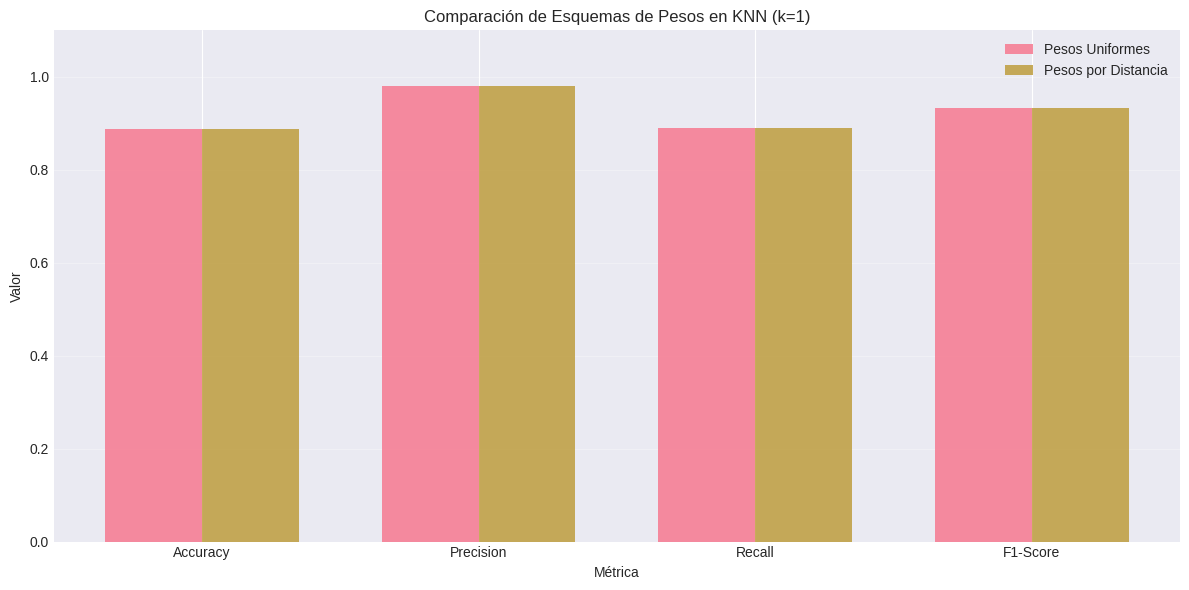

In [23]:
# ============================================================================
# 12.4. Comparación de Pesos (Uniform vs Distance)
# ============================================================================

print("\n" + "-"*80)
print("COMPARACIÓN DE ESQUEMAS DE PESOS")
print("-"*80)

# KNN con pesos uniformes
knn_uniform = KNeighborsClassifier(n_neighbors=best_k, weights='uniform')
knn_uniform.fit(X_train_scaled, y_train)
y_pred_uniform = knn_uniform.predict(X_test_scaled)

# KNN con pesos por distancia
knn_distance = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn_distance.fit(X_train_scaled, y_train)
y_pred_distance = knn_distance.predict(X_test_scaled)

print(f"\nComparación con k={best_k}:")
print(f"\nPesos Uniformes:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_uniform):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_uniform):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_uniform):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_uniform):.4f}")

print(f"\nPesos por Distancia:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_distance):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_distance):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_distance):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_distance):.4f}")

# Comparación visual
comparison_data = {
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Uniform': [
        accuracy_score(y_test, y_pred_uniform),
        precision_score(y_test, y_pred_uniform),
        recall_score(y_test, y_pred_uniform),
        f1_score(y_test, y_pred_uniform)
    ],
    'Distance': [
        accuracy_score(y_test, y_pred_distance),
        precision_score(y_test, y_pred_distance),
        recall_score(y_test, y_pred_distance),
        f1_score(y_test, y_pred_distance)
    ]
}

comparison_df = pd.DataFrame(comparison_data)

plt.figure(figsize=(12, 6))
x = np.arange(len(comparison_df['Métrica']))
width = 0.35

plt.bar(x - width/2, comparison_df['Uniform'], width, label='Pesos Uniformes', alpha=0.8)
plt.bar(x + width/2, comparison_df['Distance'], width, label='Pesos por Distancia', alpha=0.8)

plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.title(f'Comparación de Esquemas de Pesos en KNN (k={best_k})')
plt.xticks(x, comparison_df['Métrica'])
plt.legend()
plt.ylim([0, 1.1])
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
CURVA ROC
--------------------------------------------------------------------------------


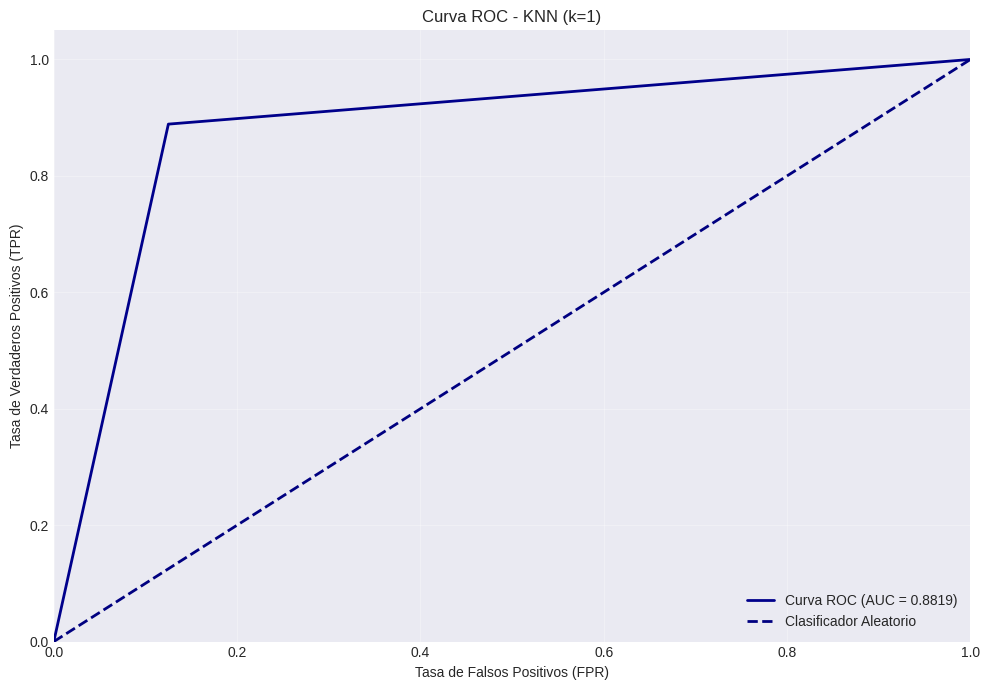

In [24]:
# ============================================================================
# 12.5. Curva ROC
# ============================================================================

print("\n" + "-"*80)
print("CURVA ROC")
print("-"*80)

# Calcular la curva ROC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn_best)
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn_best)

# Visualizar la curva ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr_knn, tpr_knn, color='darkblue', lw=2,
         label=f'Curva ROC (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title(f'Curva ROC - KNN (k={best_k})')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
VALIDACIÓN CRUZADA
--------------------------------------------------------------------------------

Puntajes de Validación Cruzada (5-fold) con k=1:
Fold 1: 0.9400
Fold 2: 0.8800
Fold 3: 0.9184
Fold 4: 0.8776
Fold 5: 0.8776

Promedio de Accuracy: 0.8987
Desviación Estándar: 0.0258


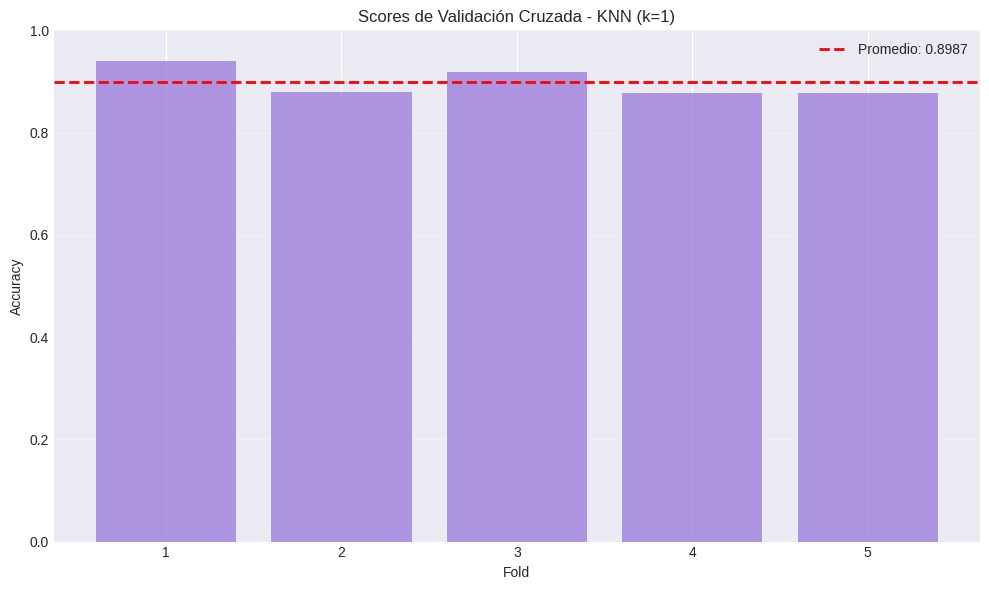

In [25]:
# ============================================================================
# 12.6. Validación Cruzada
# ============================================================================

print("\n" + "-"*80)
print("VALIDACIÓN CRUZADA")
print("-"*80)

# Realizar validación cruzada con el mejor k
cv_scores_knn = cross_val_score(knn_best, X_train_scaled, y_train,
                                cv=5, scoring='accuracy')

print(f"\nPuntajes de Validación Cruzada (5-fold) con k={best_k}:")
for i, score in enumerate(cv_scores_knn, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nPromedio de Accuracy: {cv_scores_knn.mean():.4f}")
print(f"Desviación Estándar: {cv_scores_knn.std():.4f}")

# Visualización de scores de validación cruzada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_scores_knn) + 1), cv_scores_knn, color='mediumpurple', alpha=0.7)
plt.axhline(y=cv_scores_knn.mean(), color='red', linestyle='--',
            linewidth=2, label=f'Promedio: {cv_scores_knn.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'Scores de Validación Cruzada - KNN (k={best_k})')
plt.legend()
plt.ylim([0, 1])
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [26]:
# ============================================================================
# 12.7. Optimización de Hiperparámetros con GridSearchCV
# ============================================================================

print("\n" + "-"*80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("-"*80)

# Definir grid de parámetros
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Para métrica minkowski
}

# Crear GridSearchCV
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nBuscando mejores hiperparámetros...")
grid_search_knn.fit(X_train_scaled, y_train)

print(f"\nMejores parámetros encontrados:")
for param, value in grid_search_knn.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor score de validación cruzada: {grid_search_knn.best_score_:.4f}")

# Evaluar el mejor modelo
best_knn_grid = grid_search_knn.best_estimator_
y_pred_best_grid = best_knn_grid.predict(X_test_scaled)

print(f"\nAccuracy en conjunto de prueba (modelo optimizado): {accuracy_score(y_test, y_pred_best_grid):.4f}")


--------------------------------------------------------------------------------
OPTIMIZACIÓN DE HIPERPARÁMETROS
--------------------------------------------------------------------------------

Buscando mejores hiperparámetros...
Fitting 5 folds for each of 84 candidates, totalling 420 fits

Mejores parámetros encontrados:
  metric: manhattan
  n_neighbors: 11
  p: 1
  weights: distance

Mejor score de validación cruzada: 0.9231

Accuracy en conjunto de prueba (modelo optimizado): 0.8710



--------------------------------------------------------------------------------
ANÁLISIS DE MÉTRICAS DE DISTANCIA
--------------------------------------------------------------------------------

Comparación de Métricas de Distancia (k=1):
           Accuracy  Precision    Recall  F1-Score
euclidean  0.887097   0.979592  0.888889  0.932039
manhattan  0.903226   0.980000  0.907407  0.942308
chebyshev  0.870968   0.960000  0.888889  0.923077


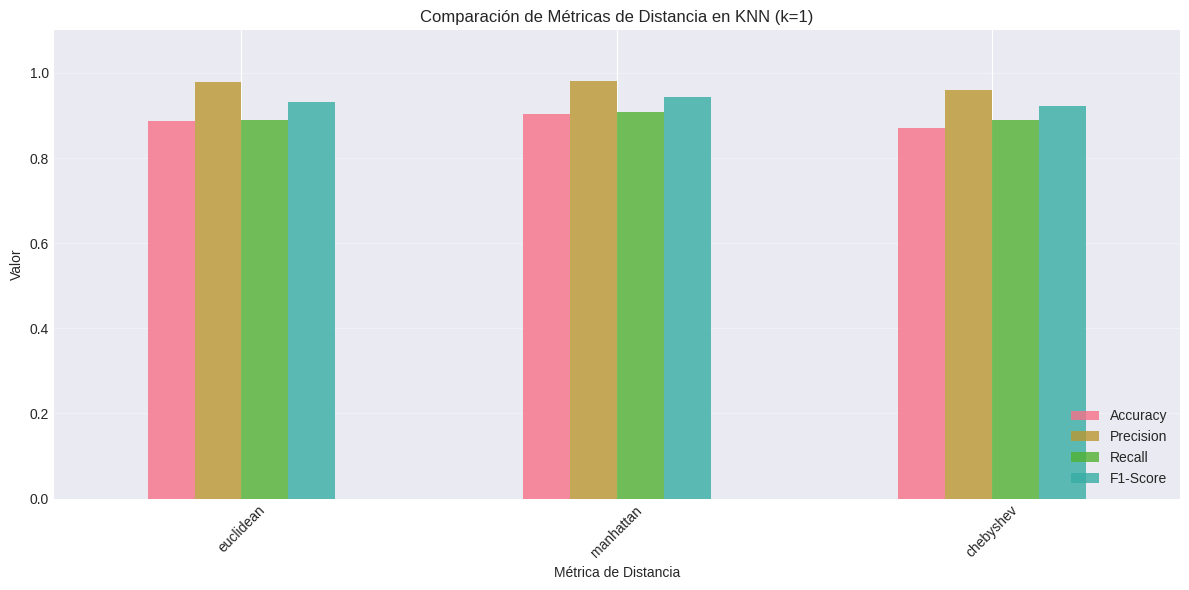

In [27]:
# ============================================================================
# 12.8. Análisis de Distancias
# ============================================================================

print("\n" + "-"*80)
print("ANÁLISIS DE MÉTRICAS DE DISTANCIA")
print("-"*80)

# Probar diferentes métricas de distancia
distance_metrics = ['euclidean', 'manhattan', 'chebyshev']
metric_results = {}

for metric in distance_metrics:
    knn_metric = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
    knn_metric.fit(X_train_scaled, y_train)
    y_pred_metric = knn_metric.predict(X_test_scaled)

    metric_results[metric] = {
        'Accuracy': accuracy_score(y_test, y_pred_metric),
        'Precision': precision_score(y_test, y_pred_metric),
        'Recall': recall_score(y_test, y_pred_metric),
        'F1-Score': f1_score(y_test, y_pred_metric)
    }

# Mostrar resultados
print(f"\nComparación de Métricas de Distancia (k={best_k}):")
results_df = pd.DataFrame(metric_results).T
print(results_df)

# Visualización
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax, alpha=0.8)
plt.title(f'Comparación de Métricas de Distancia en KNN (k={best_k})')
plt.xlabel('Métrica de Distancia')
plt.ylabel('Valor')
plt.ylim([0, 1.1])
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
MATRIZ DE CONFUSIÓN - MODELO OPTIMIZADO
--------------------------------------------------------------------------------


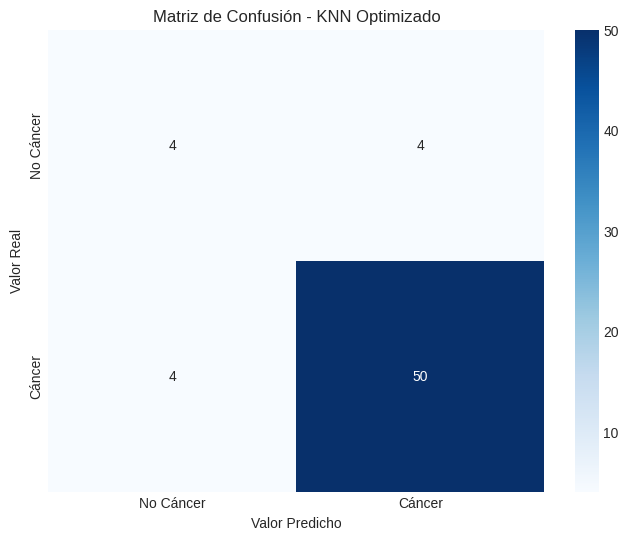


Reporte de Clasificación - Modelo Optimizado:
              precision    recall  f1-score   support

   No Cáncer       0.50      0.50      0.50         8
      Cáncer       0.93      0.93      0.93        54

    accuracy                           0.87        62
   macro avg       0.71      0.71      0.71        62
weighted avg       0.87      0.87      0.87        62


✓ ANÁLISIS DE KNN (K-NEAREST NEIGHBORS) COMPLETADO


In [28]:
# ============================================================================
# 12.9. Matriz de Confusión del Mejor Modelo
# ============================================================================

print("\n" + "-"*80)
print("MATRIZ DE CONFUSIÓN - MODELO OPTIMIZADO")
print("-"*80)

# Matriz de confusión del mejor modelo
cm_knn_best = confusion_matrix(y_test, y_pred_best_grid)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cáncer', 'Cáncer'],
            yticklabels=['No Cáncer', 'Cáncer'])
plt.title('Matriz de Confusión - KNN Optimizado')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación - Modelo Optimizado:")
print(classification_report(y_test, y_pred_best_grid,
                          target_names=['No Cáncer', 'Cáncer']))

print("\n" + "="*80)
print("✓ ANÁLISIS DE KNN (K-NEAREST NEIGHBORS) COMPLETADO")
print("="*80)

In [29]:
# ============================================================================
# 13. CLASIFICADORES BAYESIANOS
# ============================================================================

print("\n" + "="*80)
print("3.2.4. CLASIFICADORES BAYESIANOS")
print("="*80)


3.2.4. CLASIFICADORES BAYESIANOS



--------------------------------------------------------------------------------
GAUSSIAN NAIVE BAYES
--------------------------------------------------------------------------------

Métricas de Clasificación - Gaussian Naive Bayes:
Exactitud (Accuracy): 0.8548
Precisión (Precision): 0.9245
Sensibilidad (Recall): 0.9074
F1-Score: 0.9159
AUC-ROC: 0.9190

Matriz de Confusión:
[[ 4  4]
 [ 5 49]]


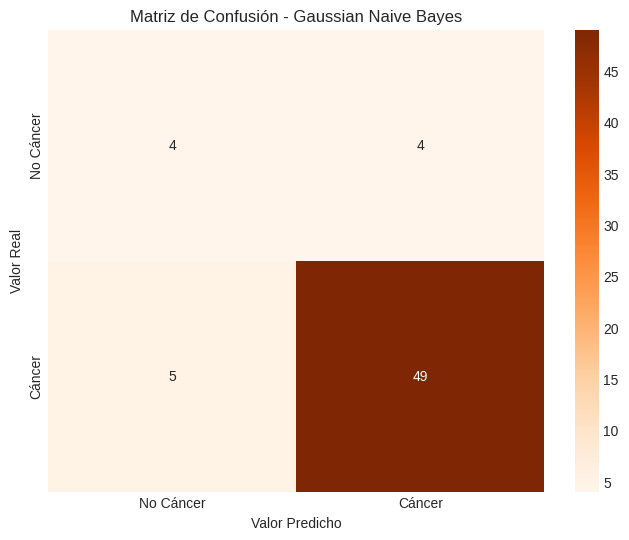


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

   No Cáncer       0.44      0.50      0.47         8
      Cáncer       0.92      0.91      0.92        54

    accuracy                           0.85        62
   macro avg       0.68      0.70      0.69        62
weighted avg       0.86      0.85      0.86        62



In [30]:
# ============================================================================
# 13.1. Gaussian Naive Bayes
# ============================================================================

print("\n" + "-"*80)
print("GAUSSIAN NAIVE BAYES")
print("-"*80)

# Entrenar modelo Gaussian Naive Bayes
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_scaled, y_train)

# Predicciones
y_pred_gnb = gnb_classifier.predict(X_test_scaled)
y_pred_proba_gnb = gnb_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluación del modelo
print("\nMétricas de Clasificación - Gaussian Naive Bayes:")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_gnb):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred_gnb):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred_gnb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gnb):.4f}")

# AUC-ROC
try:
    auc_score_gnb = roc_auc_score(y_test, y_pred_proba_gnb)
    print(f"AUC-ROC: {auc_score_gnb:.4f}")
except:
    print("AUC-ROC: No se pudo calcular")

# Matriz de confusión
print("\nMatriz de Confusión:")
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print(cm_gnb)

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Cáncer', 'Cáncer'],
            yticklabels=['No Cáncer', 'Cáncer'])
plt.title('Matriz de Confusión - Gaussian Naive Bayes')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_gnb,
                          target_names=['No Cáncer', 'Cáncer']))


--------------------------------------------------------------------------------
BERNOULLI NAIVE BAYES
--------------------------------------------------------------------------------

Métricas de Clasificación - Bernoulli Naive Bayes:
Exactitud (Accuracy): 0.8710
Precisión (Precision): 0.8710
Sensibilidad (Recall): 1.0000
F1-Score: 0.9310
AUC-ROC: 0.4560

Matriz de Confusión:
[[ 0  8]
 [ 0 54]]


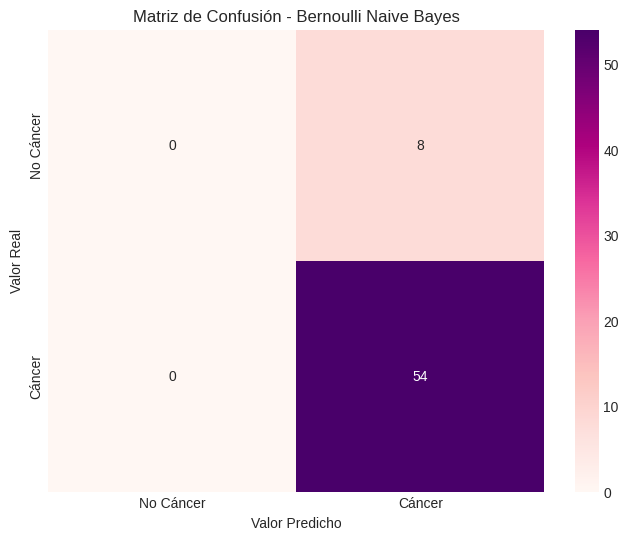


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

   No Cáncer       0.00      0.00      0.00         8
      Cáncer       0.87      1.00      0.93        54

    accuracy                           0.87        62
   macro avg       0.44      0.50      0.47        62
weighted avg       0.76      0.87      0.81        62



In [31]:
# ============================================================================
# 13.2. Bernoulli Naive Bayes
# ============================================================================

print("\n" + "-"*80)
print("BERNOULLI NAIVE BAYES")
print("-"*80)

# Entrenar modelo Bernoulli Naive Bayes
# Este modelo asume características binarias, útil cuando los datos son 0/1
bnb_classifier = BernoulliNB()
bnb_classifier.fit(X_train, y_train)  # Usar datos sin escalar para Bernoulli

# Predicciones
y_pred_bnb = bnb_classifier.predict(X_test)
y_pred_proba_bnb = bnb_classifier.predict_proba(X_test)[:, 1]

# Evaluación del modelo
print("\nMétricas de Clasificación - Bernoulli Naive Bayes:")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_bnb):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred_bnb):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred_bnb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_bnb):.4f}")

# AUC-ROC
try:
    auc_score_bnb = roc_auc_score(y_test, y_pred_proba_bnb)
    print(f"AUC-ROC: {auc_score_bnb:.4f}")
except:
    print("AUC-ROC: No se pudo calcular")

# Matriz de confusión
print("\nMatriz de Confusión:")
cm_bnb = confusion_matrix(y_test, y_pred_bnb)
print(cm_bnb)

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='RdPu',
            xticklabels=['No Cáncer', 'Cáncer'],
            yticklabels=['No Cáncer', 'Cáncer'])
plt.title('Matriz de Confusión - Bernoulli Naive Bayes')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_bnb,
                          target_names=['No Cáncer', 'Cáncer']))



--------------------------------------------------------------------------------
MULTINOMIAL NAIVE BAYES
--------------------------------------------------------------------------------

Métricas de Clasificación - Multinomial Naive Bayes:
Exactitud (Accuracy): 0.8710
Precisión (Precision): 0.8710
Sensibilidad (Recall): 1.0000
F1-Score: 0.9310
AUC-ROC: 0.6644

Matriz de Confusión:
[[ 0  8]
 [ 0 54]]


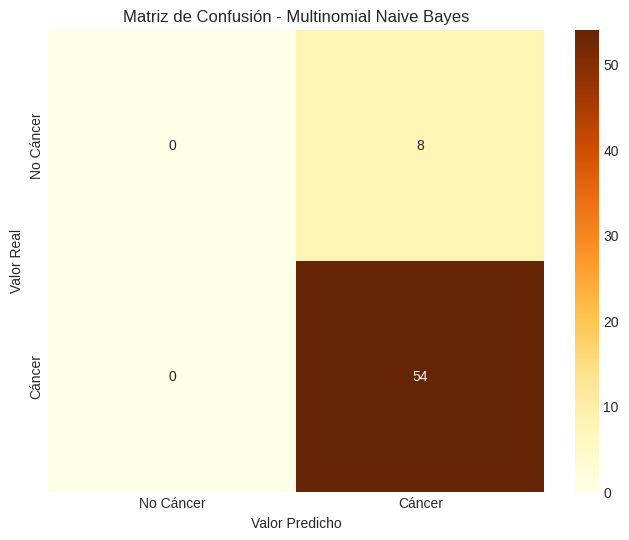


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

   No Cáncer       0.00      0.00      0.00         8
      Cáncer       0.87      1.00      0.93        54

    accuracy                           0.87        62
   macro avg       0.44      0.50      0.47        62
weighted avg       0.76      0.87      0.81        62



In [32]:
# ============================================================================
# 13.3. Multinomial Naive Bayes
# ============================================================================

print("\n" + "-"*80)
print("MULTINOMIAL NAIVE BAYES")
print("-"*80)

# Para Multinomial NB, los datos deben ser no negativos
# Aplicar transformación si hay valores negativos
X_train_multinomial = X_train.copy()
X_test_multinomial = X_test.copy()

# Si hay valores negativos, escalar al rango [0, inf)
if (X_train_multinomial < 0).any().any():
    from sklearn.preprocessing import MinMaxScaler
    scaler_multi = MinMaxScaler()
    X_train_multinomial = scaler_multi.fit_transform(X_train_multinomial)
    X_test_multinomial = scaler_multi.transform(X_test_multinomial)
    print("Datos escalados a rango [0,1] para Multinomial NB")

# Entrenar modelo Multinomial Naive Bayes
mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train_multinomial, y_train)

# Predicciones
y_pred_mnb = mnb_classifier.predict(X_test_multinomial)
y_pred_proba_mnb = mnb_classifier.predict_proba(X_test_multinomial)[:, 1]

# Evaluación del modelo
print("\nMétricas de Clasificación - Multinomial Naive Bayes:")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_mnb):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred_mnb):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred_mnb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_mnb):.4f}")

# AUC-ROC
try:
    auc_score_mnb = roc_auc_score(y_test, y_pred_proba_mnb)
    print(f"AUC-ROC: {auc_score_mnb:.4f}")
except:
    print("AUC-ROC: No se pudo calcular")

# Matriz de confusión
print("\nMatriz de Confusión:")
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
print(cm_mnb)

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=['No Cáncer', 'Cáncer'],
            yticklabels=['No Cáncer', 'Cáncer'])
plt.title('Matriz de Confusión - Multinomial Naive Bayes')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_mnb,
                          target_names=['No Cáncer', 'Cáncer']))



--------------------------------------------------------------------------------
COMPARACIÓN DE CLASIFICADORES BAYESIANOS
--------------------------------------------------------------------------------

Tabla Comparativa de Clasificadores Bayesianos:
                Accuracy  Precision    Recall  F1-Score   AUC-ROC
Gaussian NB     0.854839   0.924528  0.907407  0.915888  0.918981
Bernoulli NB    0.870968   0.870968  1.000000  0.931034  0.456019
Multinomial NB  0.870968   0.870968  1.000000  0.931034  0.664352


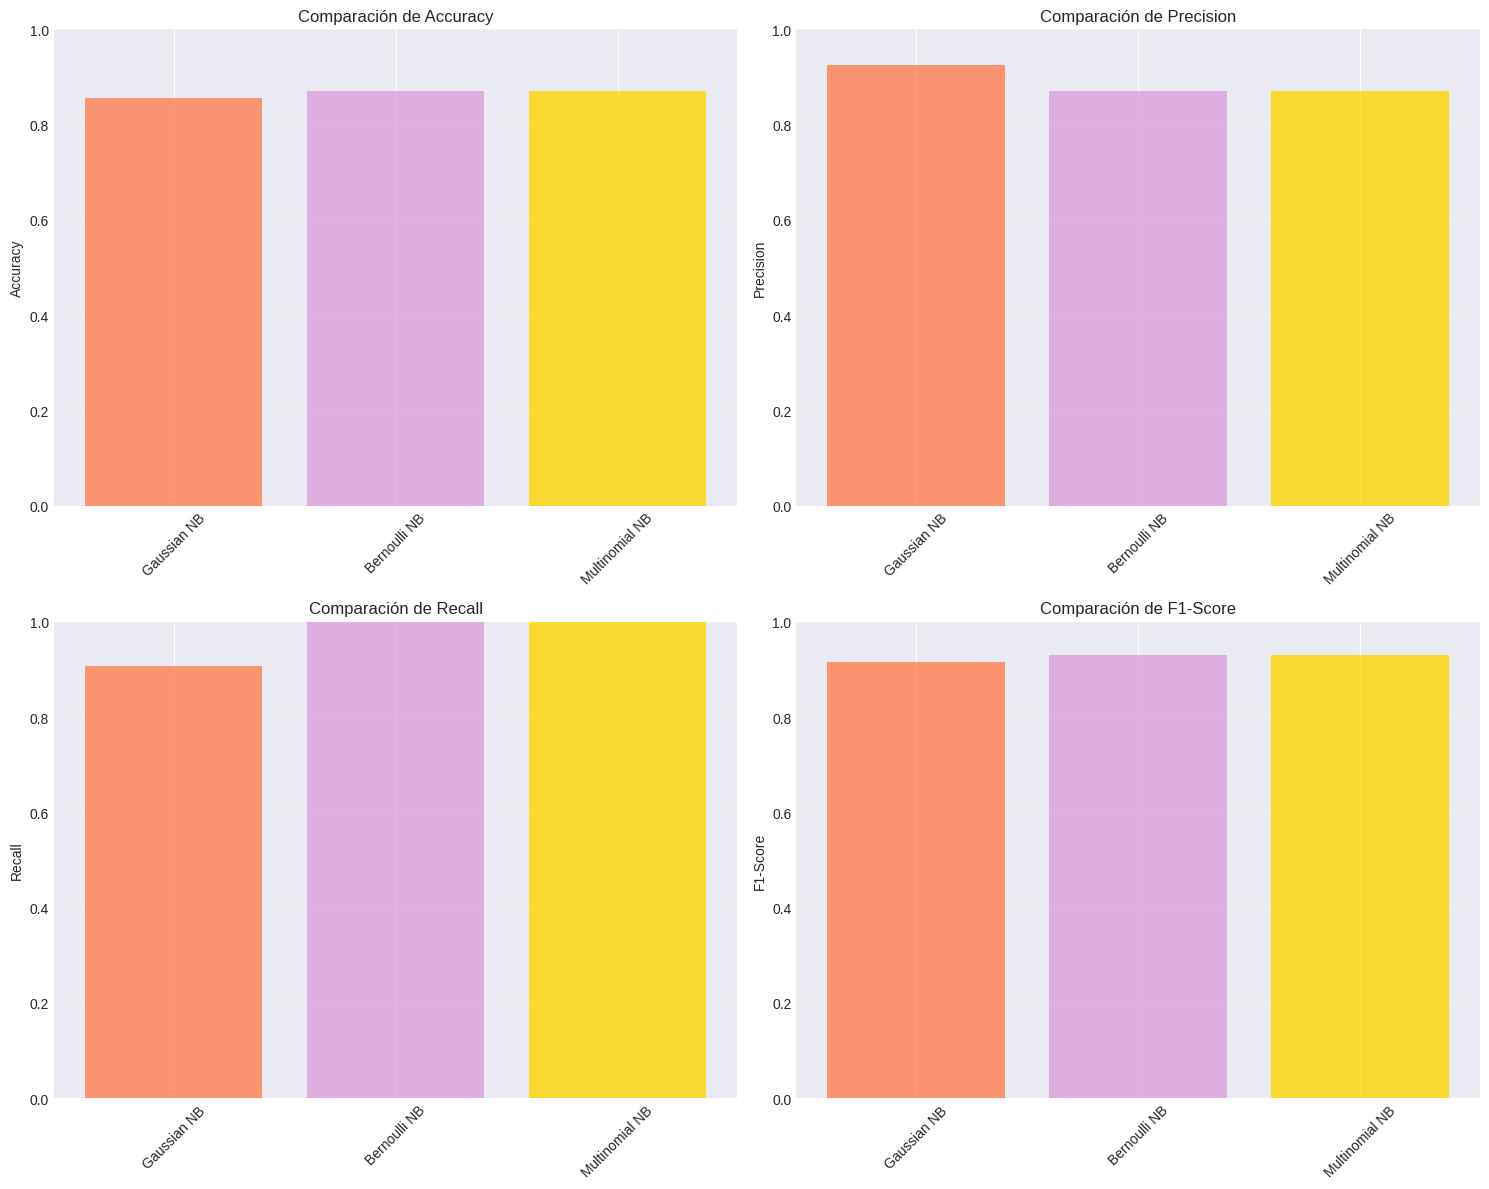

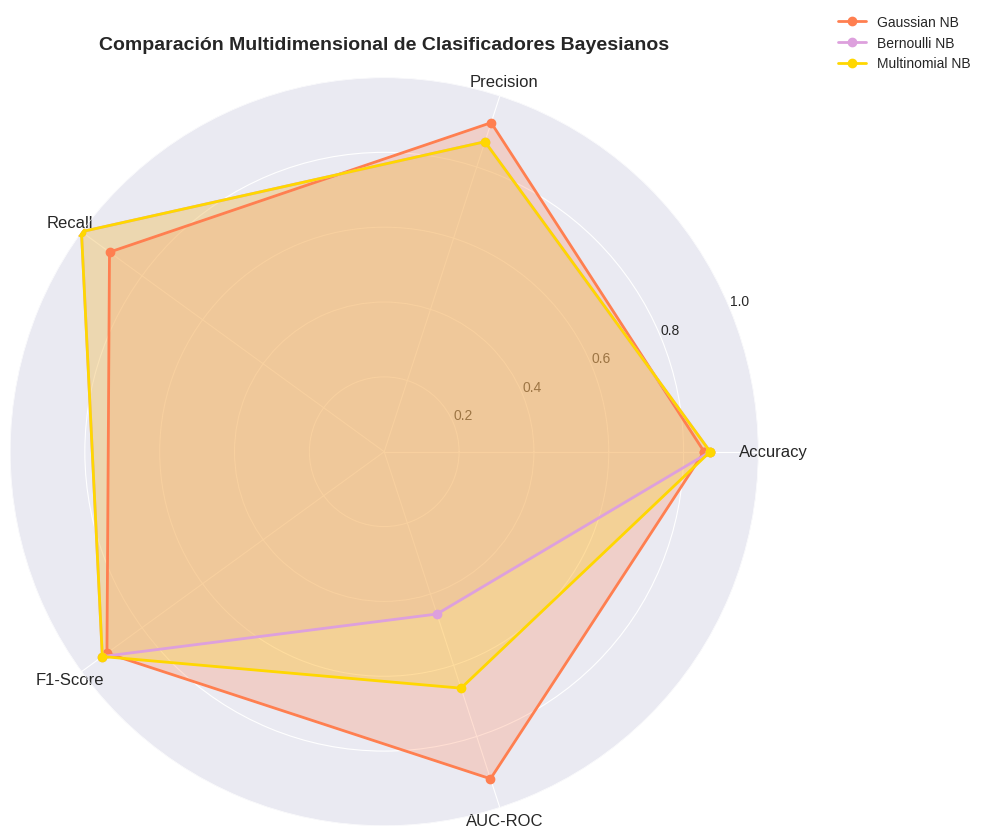

In [33]:
# ============================================================================
# 13.4. Comparación de Clasificadores Bayesianos
# ============================================================================

print("\n" + "-"*80)
print("COMPARACIÓN DE CLASIFICADORES BAYESIANOS")
print("-"*80)

# Crear diccionario con resultados
bayesian_results = {
    'Gaussian NB': {
        'Accuracy': accuracy_score(y_test, y_pred_gnb),
        'Precision': precision_score(y_test, y_pred_gnb),
        'Recall': recall_score(y_test, y_pred_gnb),
        'F1-Score': f1_score(y_test, y_pred_gnb),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba_gnb)
    },
    'Bernoulli NB': {
        'Accuracy': accuracy_score(y_test, y_pred_bnb),
        'Precision': precision_score(y_test, y_pred_bnb),
        'Recall': recall_score(y_test, y_pred_bnb),
        'F1-Score': f1_score(y_test, y_pred_bnb),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba_bnb)
    },
    'Multinomial NB': {
        'Accuracy': accuracy_score(y_test, y_pred_mnb),
        'Precision': precision_score(y_test, y_pred_mnb),
        'Recall': recall_score(y_test, y_pred_mnb),
        'F1-Score': f1_score(y_test, y_pred_mnb),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba_mnb)
    }
}

# Convertir a DataFrame
bayesian_comparison_df = pd.DataFrame(bayesian_results).T

print("\nTabla Comparativa de Clasificadores Bayesianos:")
print(bayesian_comparison_df)

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Accuracy
axes[0, 0].bar(bayesian_comparison_df.index, bayesian_comparison_df['Accuracy'],
               color=['coral', 'plum', 'gold'], alpha=0.8)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Comparación de Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: Precision
axes[0, 1].bar(bayesian_comparison_df.index, bayesian_comparison_df['Precision'],
               color=['coral', 'plum', 'gold'], alpha=0.8)
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Comparación de Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gráfico 3: Recall
axes[1, 0].bar(bayesian_comparison_df.index, bayesian_comparison_df['Recall'],
               color=['coral', 'plum', 'gold'], alpha=0.8)
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Comparación de Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# Gráfico 4: F1-Score
axes[1, 1].bar(bayesian_comparison_df.index, bayesian_comparison_df['F1-Score'],
               color=['coral', 'plum', 'gold'], alpha=0.8)
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('Comparación de F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Gráfico de radar para comparación multidimensional
from math import pi

categories = list(bayesian_comparison_df.columns)
N = len(categories)

# Crear ángulos para cada métrica
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Colores para cada clasificador
colors = ['coral', 'plum', 'gold']

# Plotear cada clasificador
for idx, (classifier, color) in enumerate(zip(bayesian_comparison_df.index, colors)):
    values = bayesian_comparison_df.loc[classifier].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=classifier, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

# Configurar el gráfico
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.grid(True)
ax.set_title('Comparación Multidimensional de Clasificadores Bayesianos',
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()



--------------------------------------------------------------------------------
CURVAS ROC COMPARATIVAS
--------------------------------------------------------------------------------


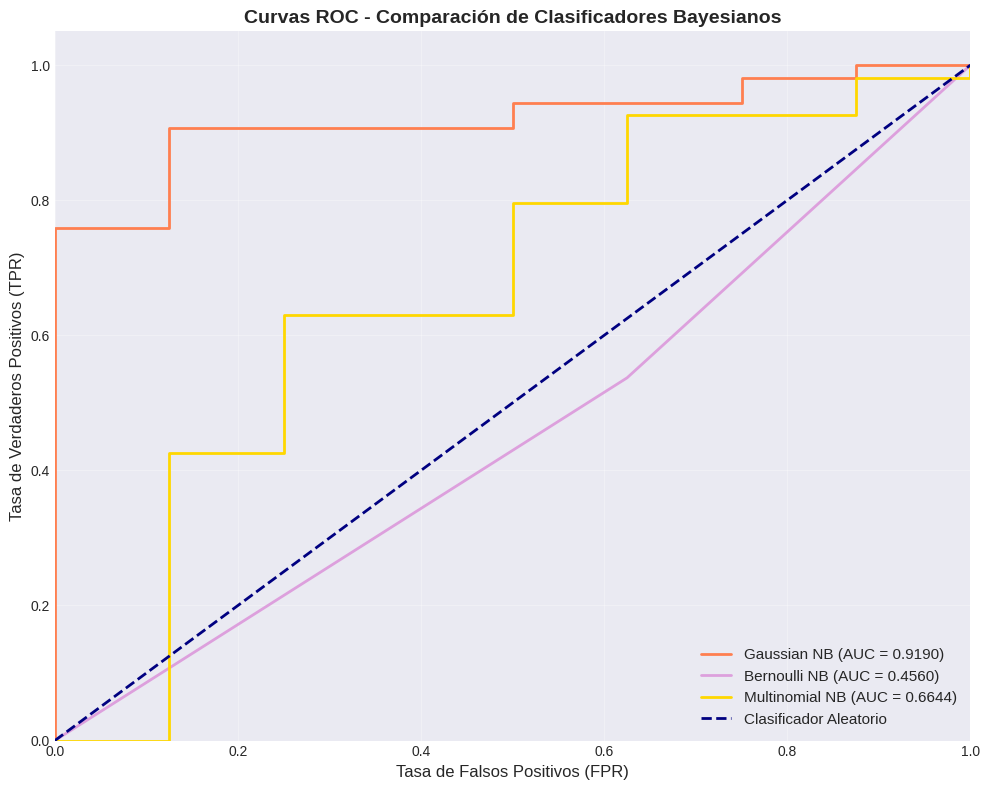

In [34]:
# ============================================================================
# 13.5. Curvas ROC Comparativas
# ============================================================================

print("\n" + "-"*80)
print("CURVAS ROC COMPARATIVAS")
print("-"*80)

# Calcular curvas ROC para cada clasificador
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_pred_proba_gnb)
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_pred_proba_bnb)
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_pred_proba_mnb)

# Visualizar todas las curvas ROC juntas
plt.figure(figsize=(10, 8))

plt.plot(fpr_gnb, tpr_gnb, color='coral', lw=2,
         label=f'Gaussian NB (AUC = {auc_score_gnb:.4f})')
plt.plot(fpr_bnb, tpr_bnb, color='plum', lw=2,
         label=f'Bernoulli NB (AUC = {auc_score_bnb:.4f})')
plt.plot(fpr_mnb, tpr_mnb, color='gold', lw=2,
         label=f'Multinomial NB (AUC = {auc_score_mnb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Clasificador Aleatorio')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curvas ROC - Comparación de Clasificadores Bayesianos', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
VALIDACIÓN CRUZADA
--------------------------------------------------------------------------------

Resultados de Validación Cruzada (5-fold):

Gaussian Naive Bayes:
  Promedio: 0.8988
  Desviación Estándar: 0.0441

Bernoulli Naive Bayes:
  Promedio: 0.8745
  Desviación Estándar: 0.0073

Multinomial Naive Bayes:
  Promedio: 0.8745
  Desviación Estándar: 0.0073


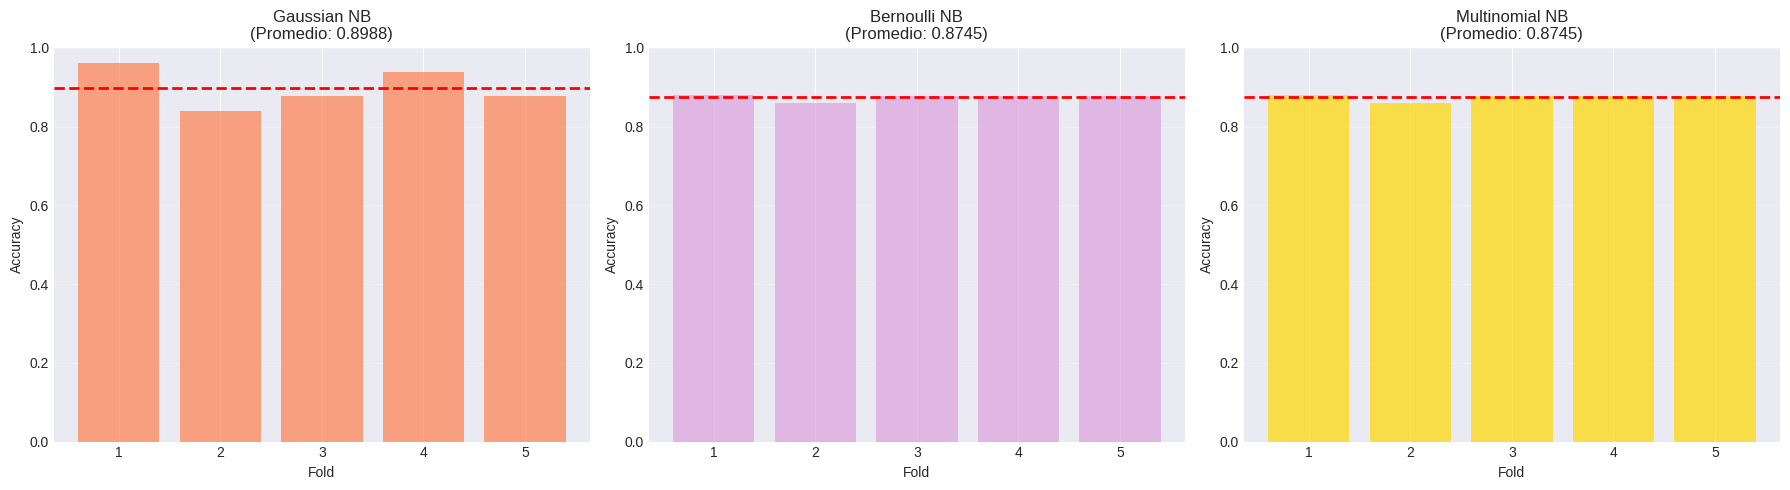

In [35]:
# ============================================================================
# 13.6. Validación Cruzada
# ============================================================================

print("\n" + "-"*80)
print("VALIDACIÓN CRUZADA")
print("-"*80)

# Validación cruzada para cada clasificador
cv_gnb = cross_val_score(gnb_classifier, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_bnb = cross_val_score(bnb_classifier, X_train, y_train, cv=5, scoring='accuracy')
cv_mnb = cross_val_score(mnb_classifier, X_train_multinomial, y_train, cv=5, scoring='accuracy')

print("\nResultados de Validación Cruzada (5-fold):")
print(f"\nGaussian Naive Bayes:")
print(f"  Promedio: {cv_gnb.mean():.4f}")
print(f"  Desviación Estándar: {cv_gnb.std():.4f}")

print(f"\nBernoulli Naive Bayes:")
print(f"  Promedio: {cv_bnb.mean():.4f}")
print(f"  Desviación Estándar: {cv_bnb.std():.4f}")

print(f"\nMultinomial Naive Bayes:")
print(f"  Promedio: {cv_mnb.mean():.4f}")
print(f"  Desviación Estándar: {cv_mnb.std():.4f}")

# Visualización de validación cruzada
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gaussian NB
axes[0].bar(range(1, 6), cv_gnb, color='coral', alpha=0.7)
axes[0].axhline(y=cv_gnb.mean(), color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].set_title(f'Gaussian NB\n(Promedio: {cv_gnb.mean():.4f})')
axes[0].set_ylim([0, 1])
axes[0].grid(alpha=0.3, axis='y')

# Bernoulli NB
axes[1].bar(range(1, 6), cv_bnb, color='plum', alpha=0.7)
axes[1].axhline(y=cv_bnb.mean(), color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Bernoulli NB\n(Promedio: {cv_bnb.mean():.4f})')
axes[1].set_ylim([0, 1])
axes[1].grid(alpha=0.3, axis='y')

# Multinomial NB
axes[2].bar(range(1, 6), cv_mnb, color='gold', alpha=0.7)
axes[2].axhline(y=cv_mnb.mean(), color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Accuracy')
axes[2].set_title(f'Multinomial NB\n(Promedio: {cv_mnb.mean():.4f})')
axes[2].set_ylim([0, 1])
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [36]:
# ============================================================================
# 13.7. Optimización de Hiperparámetros - Gaussian NB
# ============================================================================

print("\n" + "-"*80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - GAUSSIAN NB")
print("-"*80)

# Grid de parámetros para Gaussian NB
param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# GridSearchCV
grid_gnb = GridSearchCV(
    GaussianNB(),
    param_grid_gnb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nBuscando mejor parámetro var_smoothing para Gaussian NB...")
grid_gnb.fit(X_train_scaled, y_train)

print(f"\nMejor parámetro var_smoothing: {grid_gnb.best_params_['var_smoothing']:.2e}")
print(f"Mejor score de validación cruzada: {grid_gnb.best_score_:.4f}")

# Evaluar modelo optimizado
best_gnb = grid_gnb.best_estimator_
y_pred_best_gnb = best_gnb.predict(X_test_scaled)

print(f"Accuracy en conjunto de prueba (modelo optimizado): {accuracy_score(y_test, y_pred_best_gnb):.4f}")



--------------------------------------------------------------------------------
OPTIMIZACIÓN DE HIPERPARÁMETROS - GAUSSIAN NB
--------------------------------------------------------------------------------

Buscando mejor parámetro var_smoothing para Gaussian NB...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejor parámetro var_smoothing: 8.11e-01
Mejor score de validación cruzada: 0.9069
Accuracy en conjunto de prueba (modelo optimizado): 0.8871



--------------------------------------------------------------------------------
ANÁLISIS DE PROBABILIDADES PREDICHAS
--------------------------------------------------------------------------------

Primeras 10 predicciones de probabilidad:
   Real  Prob_Gaussian  Prob_Bernoulli  Prob_Multinomial
0     1       0.999490        0.884844          0.829837
1     1       0.999542        0.931945          0.937227
2     1       0.998829        0.884844          0.880798
3     1       0.999525        0.931945          0.927226
4     0       0.017475        0.884844          0.780337
5     1       0.998674        0.884844          0.895945
6     0       0.738070        0.931945          0.883668
7     1       0.989021        0.931945          0.899119
8     0       0.007363        0.884844          0.805306
9     1       0.999400        0.884844          0.872479


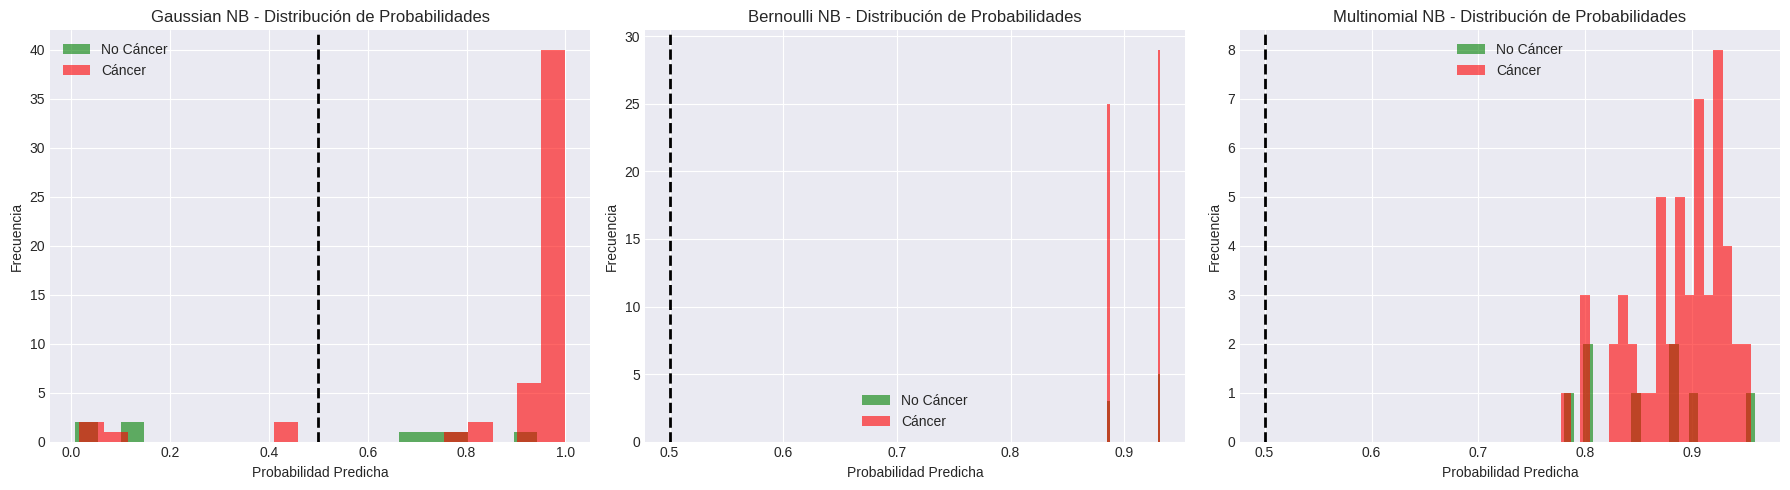

In [41]:
# ============================================================================
# 13.8. Probabilidades Predichas
# ============================================================================

print("\n" + "-"*80)
print("ANÁLISIS DE PROBABILIDADES PREDICHAS")
print("-"*80)

# Crear DataFrame con probabilidades
prob_comparison = pd.DataFrame({
    'Real': y_test,
    'Prob_Gaussian': y_pred_proba_gnb,
    'Prob_Bernoulli': y_pred_proba_bnb,
    'Prob_Multinomial': y_pred_proba_mnb
})

print("\nPrimeras 10 predicciones de probabilidad:")
print(prob_comparison.head(10))

# Visualización de distribución de probabilidades
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gaussian NB
axes[0].hist(prob_comparison[prob_comparison['Real']==0]['Prob_Gaussian'],
             bins=20, alpha=0.6, label='No Cáncer', color='green')
axes[0].hist(prob_comparison[prob_comparison['Real']==1]['Prob_Gaussian'],
             bins=20, alpha=0.6, label='Cáncer', color='red')
axes[0].set_xlabel('Probabilidad Predicha')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Gaussian NB - Distribución de Probabilidades')
axes[0].legend()
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2)

# Bernoulli NB
axes[1].hist(prob_comparison[prob_comparison['Real']==0]['Prob_Bernoulli'],
             bins=20, alpha=0.6, label='No Cáncer', color='green')
axes[1].hist(prob_comparison[prob_comparison['Real']==1]['Prob_Bernoulli'],
             bins=20, alpha=0.6, label='Cáncer', color='red')
axes[1].set_xlabel('Probabilidad Predicha')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Bernoulli NB - Distribución de Probabilidades')
axes[1].legend()
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2)

# Multinomial NB
axes[2].hist(prob_comparison[prob_comparison['Real']==0]['Prob_Multinomial'],
             bins=20, alpha=0.6, label='No Cáncer', color='green')
axes[2].hist(prob_comparison[prob_comparison['Real']==1]['Prob_Multinomial'],
             bins=20, alpha=0.6, label='Cáncer', color='red')
axes[2].set_xlabel('Probabilidad Predicha')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Multinomial NB - Distribución de Probabilidades')
axes[2].legend()
axes[2].axvline(x=0.5, color='black', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()


In [42]:
# ============================================================================
# 13.9. Mejor Clasificador Bayesiano
# ============================================================================

print("\n" + "-"*80)
print("SELECCIÓN DEL MEJOR CLASIFICADOR BAYESIANO")
print("-"*80)

# Encontrar el mejor clasificador basado en F1-Score
best_bayesian = bayesian_comparison_df['F1-Score'].idxmax()
best_f1_score = bayesian_comparison_df['F1-Score'].max()

print(f"\nMejor Clasificador Bayesiano: {best_bayesian}")
print(f"F1-Score: {best_f1_score:.4f}")
print(f"\nMétricas del mejor clasificador:")
print(bayesian_comparison_df.loc[best_bayesian])

print("\n" + "="*80)
print("✓ ANÁLISIS DE CLASIFICADORES BAYESIANOS COMPLETADO")
print("="*80)


--------------------------------------------------------------------------------
SELECCIÓN DEL MEJOR CLASIFICADOR BAYESIANO
--------------------------------------------------------------------------------

Mejor Clasificador Bayesiano: Bernoulli NB
F1-Score: 0.9310

Métricas del mejor clasificador:
Accuracy     0.870968
Precision    0.870968
Recall       1.000000
F1-Score     0.931034
AUC-ROC      0.456019
Name: Bernoulli NB, dtype: float64

✓ ANÁLISIS DE CLASIFICADORES BAYESIANOS COMPLETADO


In [43]:
# ============================================================================
# 14. ALGORITMOS NO SUPERVISADOS - AGRUPAMIENTO (CLUSTERING)
# ============================================================================

print("\n" + "="*80)
print("3.3. ALGORITMOS NO SUPERVISADOS")
print("3.3.1. AGRUPAMIENTO (CLUSTERING)")
print("="*80)


3.3. ALGORITMOS NO SUPERVISADOS
3.3.1. AGRUPAMIENTO (CLUSTERING)


In [44]:
# ============================================================================
# 14.1. Preparación de Datos para Clustering
# ============================================================================

print("\n" + "-"*80)
print("PREPARACIÓN DE DATOS PARA CLUSTERING")
print("-"*80)

# Para clustering, usaremos solo las características (X) sin la variable objetivo
# ya que es aprendizaje no supervisado
X_clustering = X_train_scaled.copy()

print(f"Datos para clustering: {X_clustering.shape}")
print(f"Número de muestras: {X_clustering.shape[0]}")
print(f"Número de características: {X_clustering.shape[1]}")


--------------------------------------------------------------------------------
PREPARACIÓN DE DATOS PARA CLUSTERING
--------------------------------------------------------------------------------
Datos para clustering: (247, 15)
Número de muestras: 247
Número de características: 15



--------------------------------------------------------------------------------
MÉTODO DEL CODO (ELBOW METHOD)
--------------------------------------------------------------------------------

Calculando inercia y silhouette score para diferentes valores de k...
k=2: Inercia=3169.05, Silhouette=0.1404
k=3: Inercia=2873.40, Silhouette=0.1462
k=4: Inercia=2653.04, Silhouette=0.1563
k=5: Inercia=2482.59, Silhouette=0.1591
k=6: Inercia=2330.24, Silhouette=0.1669
k=7: Inercia=2243.98, Silhouette=0.1674
k=8: Inercia=2160.22, Silhouette=0.1636
k=9: Inercia=2067.77, Silhouette=0.1702
k=10: Inercia=1996.06, Silhouette=0.1754


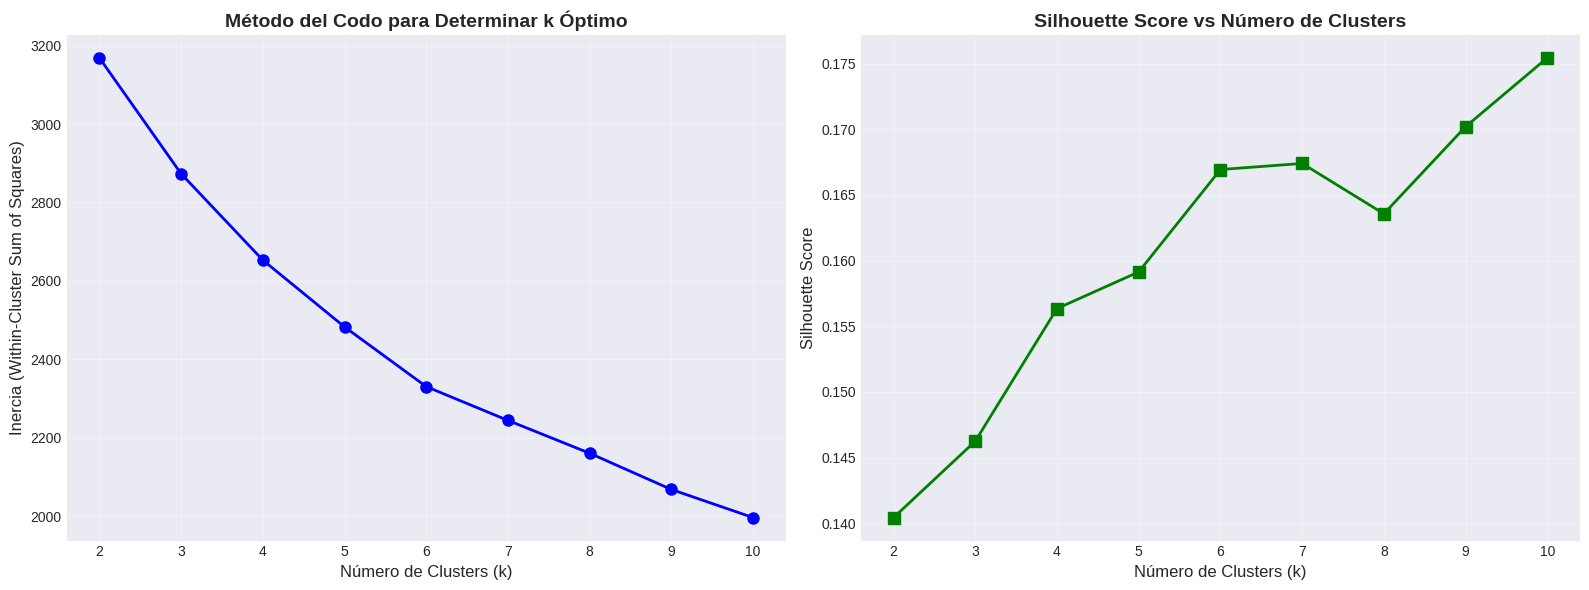


Número óptimo de clusters basado en Silhouette Score: 10
Mejor Silhouette Score: 0.1754


In [45]:
# ============================================================================
# 14.2. Determinación del Número Óptimo de Clusters
# ============================================================================

print("\n" + "-"*80)
print("MÉTODO DEL CODO (ELBOW METHOD)")
print("-"*80)

# Calcular inercia (suma de distancias cuadradas) para diferentes k
inertias = []
silhouette_scores = []
k_range = range(2, 11)

print("\nCalculando inercia y silhouette score para diferentes valores de k...")
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_clustering)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, kmeans_temp.labels_))
    print(f"k={k}: Inercia={kmeans_temp.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Visualización del Método del Codo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Método del Codo
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Método del Codo para Determinar k Óptimo', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Gráfico 2: Silhouette Score
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Número de Clusters', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar k óptimo basado en silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nNúmero óptimo de clusters basado en Silhouette Score: {optimal_k}")
print(f"Mejor Silhouette Score: {max(silhouette_scores):.4f}")



--------------------------------------------------------------------------------
K-MEANS CLUSTERING
--------------------------------------------------------------------------------

Resultados de K-Means (k=10):
Silhouette Score: 0.1754
Inercia: 1996.06
Número de iteraciones: 12

Distribución de muestras por cluster:
Cluster 0: 20 muestras (8.10%)
Cluster 1: 44 muestras (17.81%)
Cluster 2: 21 muestras (8.50%)
Cluster 3: 35 muestras (14.17%)
Cluster 4: 22 muestras (8.91%)
Cluster 5: 41 muestras (16.60%)
Cluster 6: 12 muestras (4.86%)
Cluster 7: 20 muestras (8.10%)
Cluster 8: 18 muestras (7.29%)
Cluster 9: 14 muestras (5.67%)


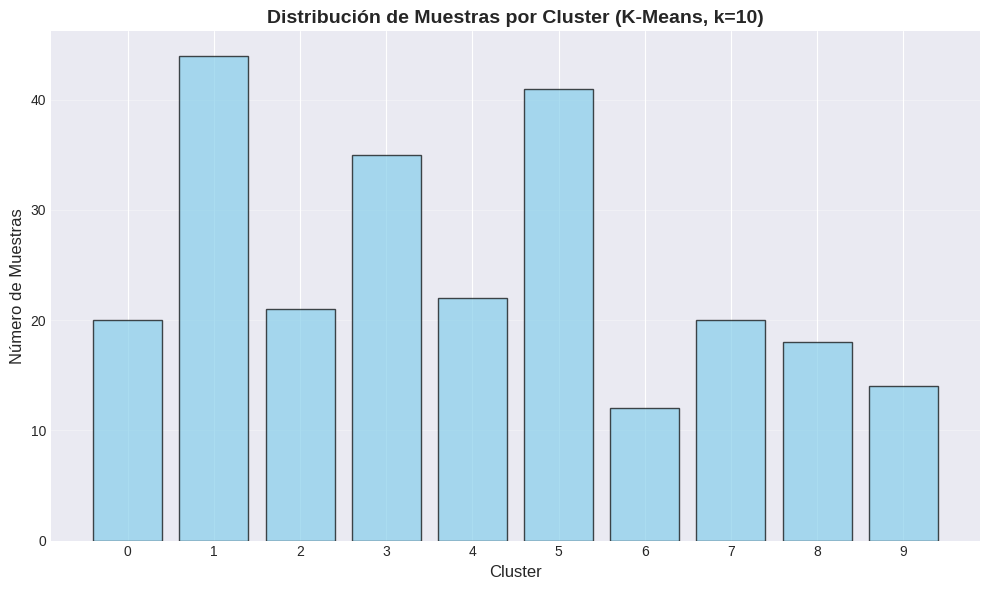

In [46]:
# ============================================================================
# 14.3. K-MEANS CLUSTERING
# ============================================================================

print("\n" + "-"*80)
print("K-MEANS CLUSTERING")
print("-"*80)

# Entrenar K-Means con el número óptimo de clusters
kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=10,
    max_iter=300
)

# Ajustar el modelo
kmeans.fit(X_clustering)

# Obtener etiquetas de clusters
cluster_labels = kmeans.labels_

# Métricas de evaluación
silhouette_avg = silhouette_score(X_clustering, cluster_labels)
inertia = kmeans.inertia_

print(f"\nResultados de K-Means (k={optimal_k}):")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Inercia: {inertia:.2f}")
print(f"Número de iteraciones: {kmeans.n_iter_}")

# Distribución de muestras por cluster
print("\nDistribución de muestras por cluster:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster_id}: {count} muestras ({percentage:.2f}%)")

# Visualización de la distribución de clusters
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Número de Muestras', fontsize=12)
plt.title(f'Distribución de Muestras por Cluster (K-Means, k={optimal_k})',
          fontsize=14, fontweight='bold')
plt.xticks(unique)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
VISUALIZACIÓN DE CLUSTERS CON PCA
--------------------------------------------------------------------------------

Varianza explicada por los 2 primeros componentes:
PC1: 0.1952 (19.52%)
PC2: 0.1301 (13.01%)
Total: 0.3253 (32.53%)


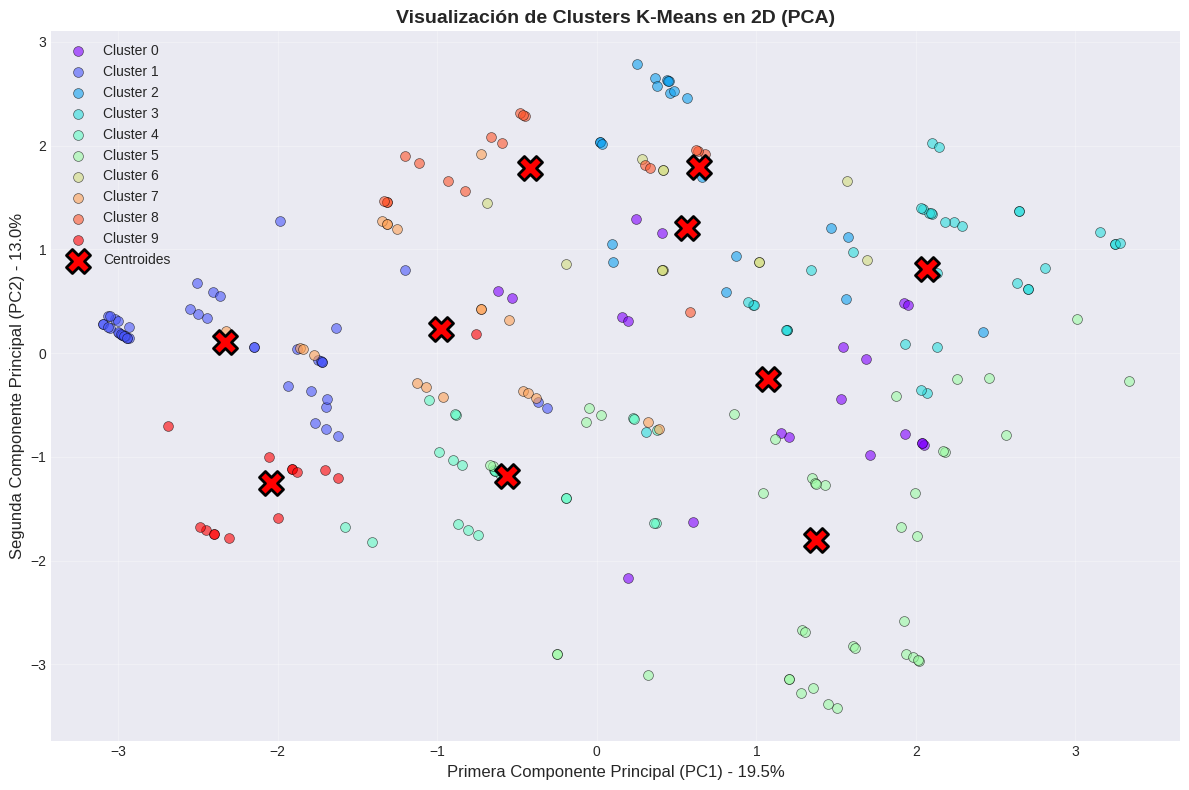

In [47]:
# ============================================================================
# 14.4. Visualización con PCA (Reducción de Dimensionalidad)
# ============================================================================

print("\n" + "-"*80)
print("VISUALIZACIÓN DE CLUSTERS CON PCA")
print("-"*80)

# Reducir dimensionalidad a 2D con PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

print(f"\nVarianza explicada por los 2 primeros componentes:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"Total: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")

# Visualización de clusters en 2D
plt.figure(figsize=(12, 8))

# Plotear puntos de cada cluster
colors = plt.cm.rainbow(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_points = X_pca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=[colors[i]], label=f'Cluster {i}',
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Plotear centroides
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red', marker='X', s=300, edgecolors='black',
            linewidth=2, label='Centroides', zorder=10)

plt.xlabel(f'Primera Componente Principal (PC1) - {pca.explained_variance_ratio_[0]*100:.1f}%',
           fontsize=12)
plt.ylabel(f'Segunda Componente Principal (PC2) - {pca.explained_variance_ratio_[1]*100:.1f}%',
           fontsize=12)
plt.title(f'Visualización de Clusters K-Means en 2D (PCA)',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER
--------------------------------------------------------------------------------

Estadísticas promedio por cluster:
           GENDER        AGE   SMOKING  YELLOW_FINGERS   ANXIETY  \
Cluster                                                            
0        0.100000  66.550000  1.050000        1.750000  1.650000   
1        1.000000  61.500000  1.750000        1.090909  1.159091   
2        0.142857  63.571429  1.619048        1.047619  1.142857   
3        0.085714  63.828571  1.885714        2.000000  2.000000   
4        0.409091  61.181818  1.363636        1.181818  1.090909   
5        0.658537  61.731707  1.707317        1.975610  1.951220   
6        0.250000  55.250000  1.750000        2.000000  1.666667   
7        0.950000  66.300000  1.000000        1.850000  1.400000   
8        0.222222  66.277778  1.000000        1.611111  1.000000   
9        1.00

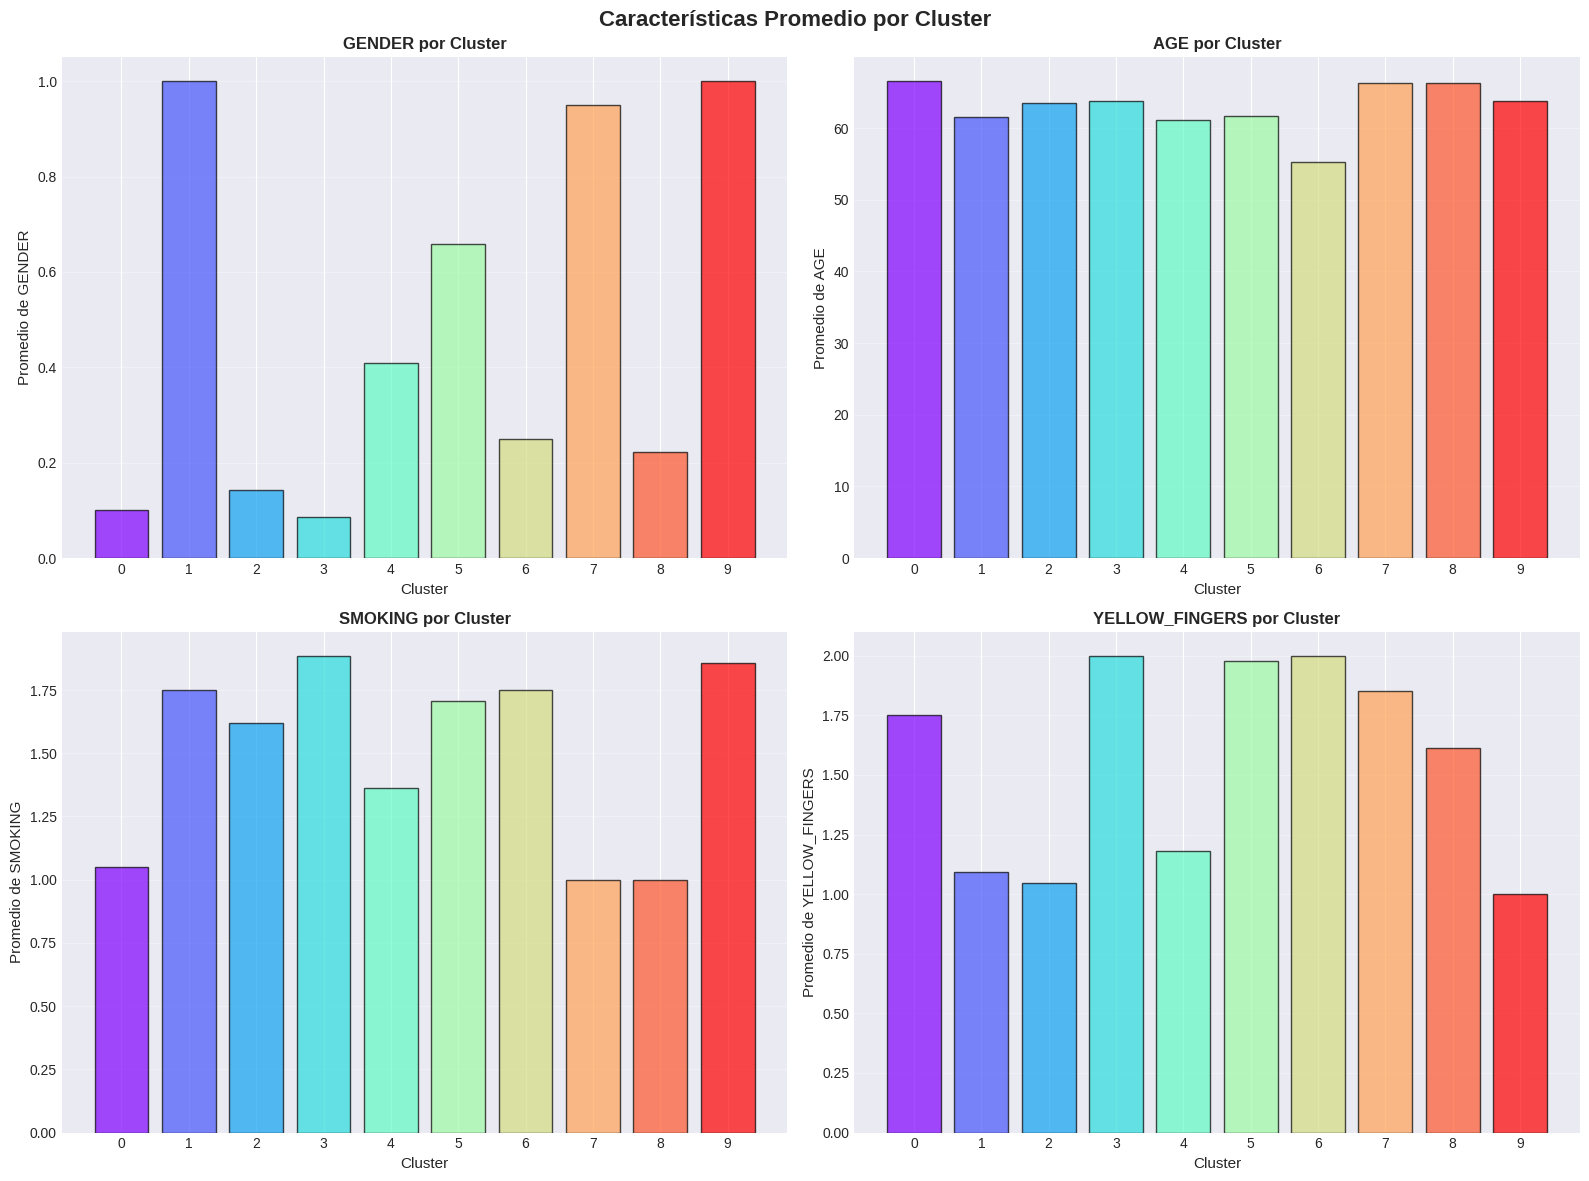

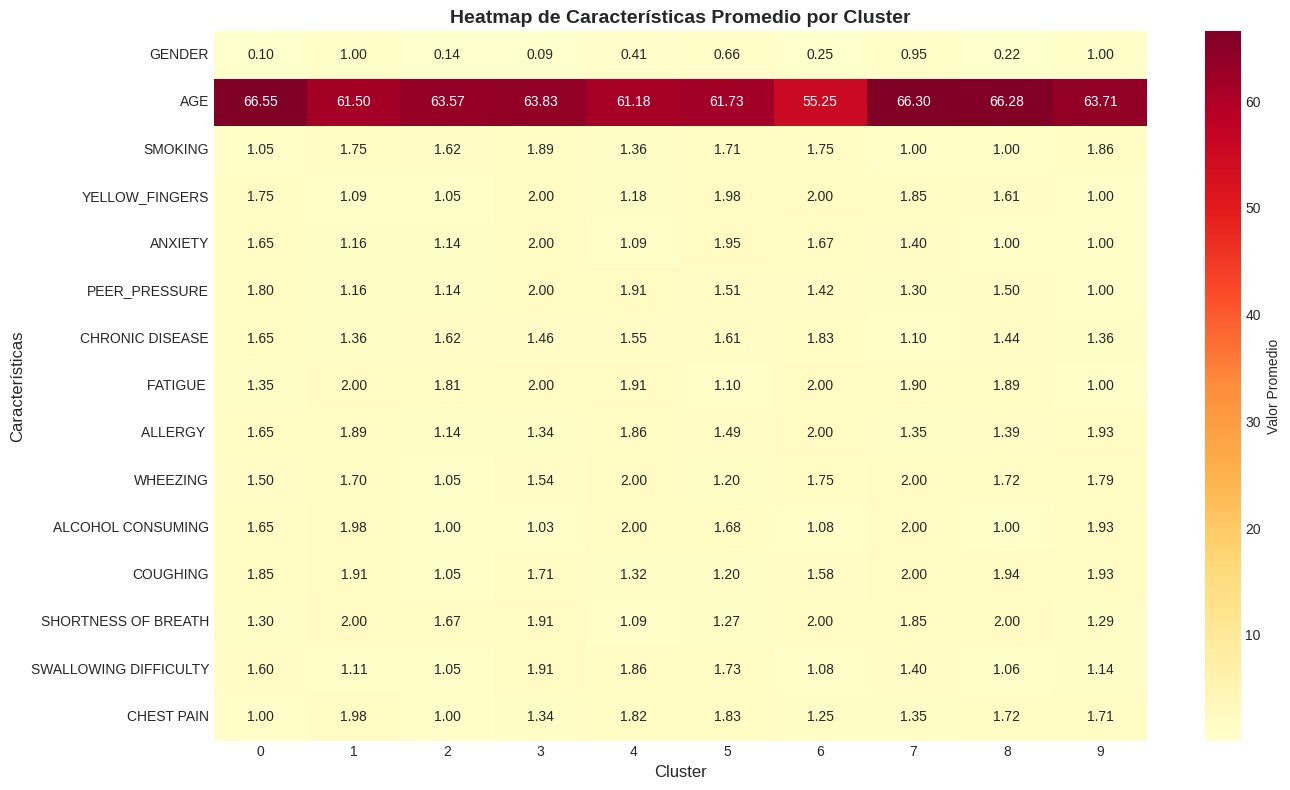

In [48]:
# ============================================================================
# 14.5. Análisis de Características por Cluster
# ============================================================================

print("\n" + "-"*80)
print("ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER")
print("-"*80)

# Crear DataFrame con datos originales y etiquetas de cluster
X_train_with_clusters = X_train.copy()
X_train_with_clusters['Cluster'] = cluster_labels

# Calcular estadísticas por cluster
print("\nEstadísticas promedio por cluster:")
cluster_stats = X_train_with_clusters.groupby('Cluster').mean()
print(cluster_stats)

# Visualización de características promedio por cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Características Promedio por Cluster', fontsize=16, fontweight='bold')

# Seleccionar algunas características importantes para visualizar
important_features = X_train.columns[:4]  # Primeras 4 características

for idx, feature in enumerate(important_features):
    ax = axes[idx // 2, idx % 2]
    cluster_means = cluster_stats[feature].values

    ax.bar(range(optimal_k), cluster_means, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Cluster', fontsize=11)
    ax.set_ylabel(f'Promedio de {feature}', fontsize=11)
    ax.set_title(f'{feature} por Cluster', fontsize=12, fontweight='bold')
    ax.set_xticks(range(optimal_k))
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Heatmap de características promedio por cluster
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_stats.T, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Valor Promedio'})
plt.title('Heatmap de Características Promedio por Cluster',
          fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
CLUSTERING JERÁRQUICO (AGGLOMERATIVE)
--------------------------------------------------------------------------------

Resultados de Clustering Jerárquico (k=10):
Silhouette Score: 0.1685

Distribución de muestras por cluster (Jerárquico):
Cluster 0: 36 muestras (14.57%)
Cluster 1: 29 muestras (11.74%)
Cluster 2: 25 muestras (10.12%)
Cluster 3: 30 muestras (12.15%)
Cluster 4: 17 muestras (6.88%)
Cluster 5: 19 muestras (7.69%)
Cluster 6: 27 muestras (10.93%)
Cluster 7: 27 muestras (10.93%)
Cluster 8: 24 muestras (9.72%)
Cluster 9: 13 muestras (5.26%)

Generando dendrograma...


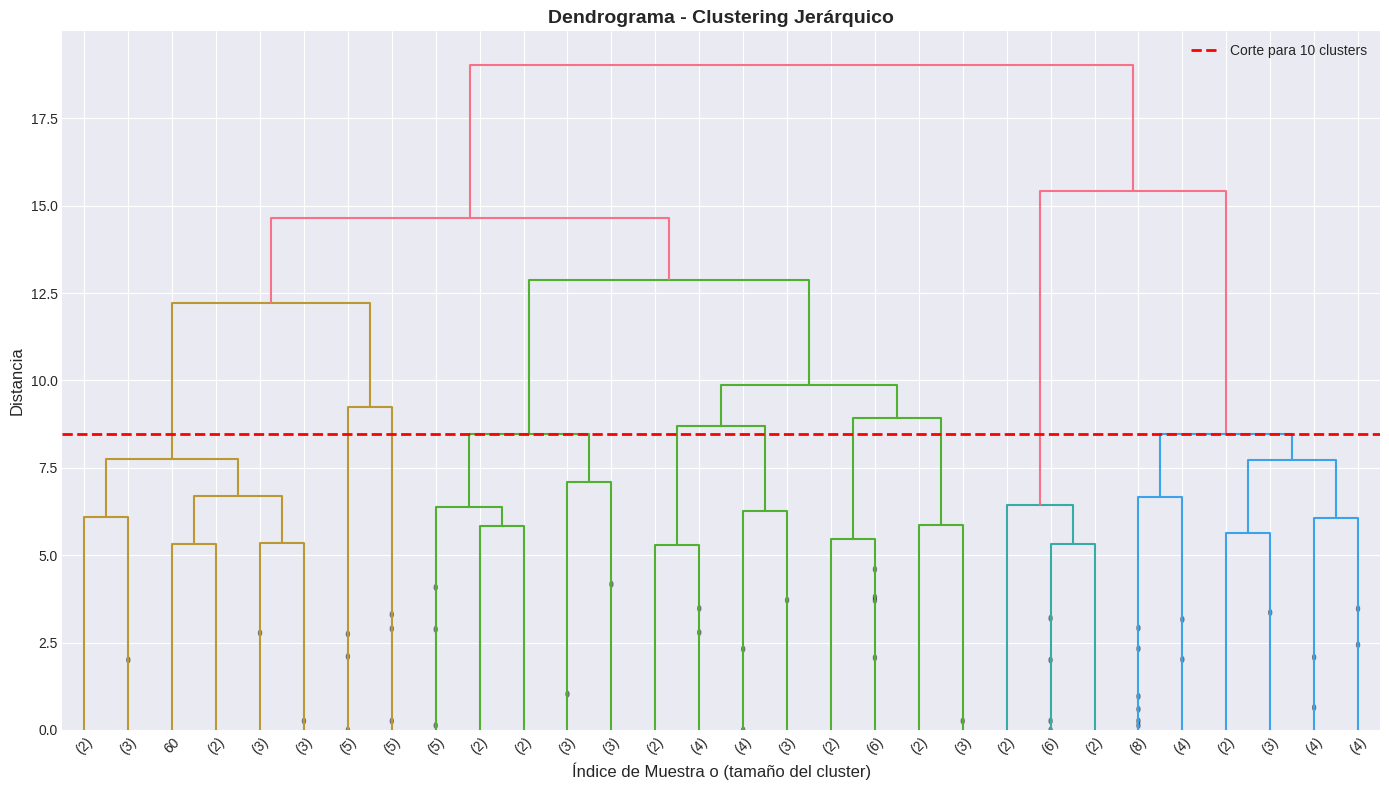

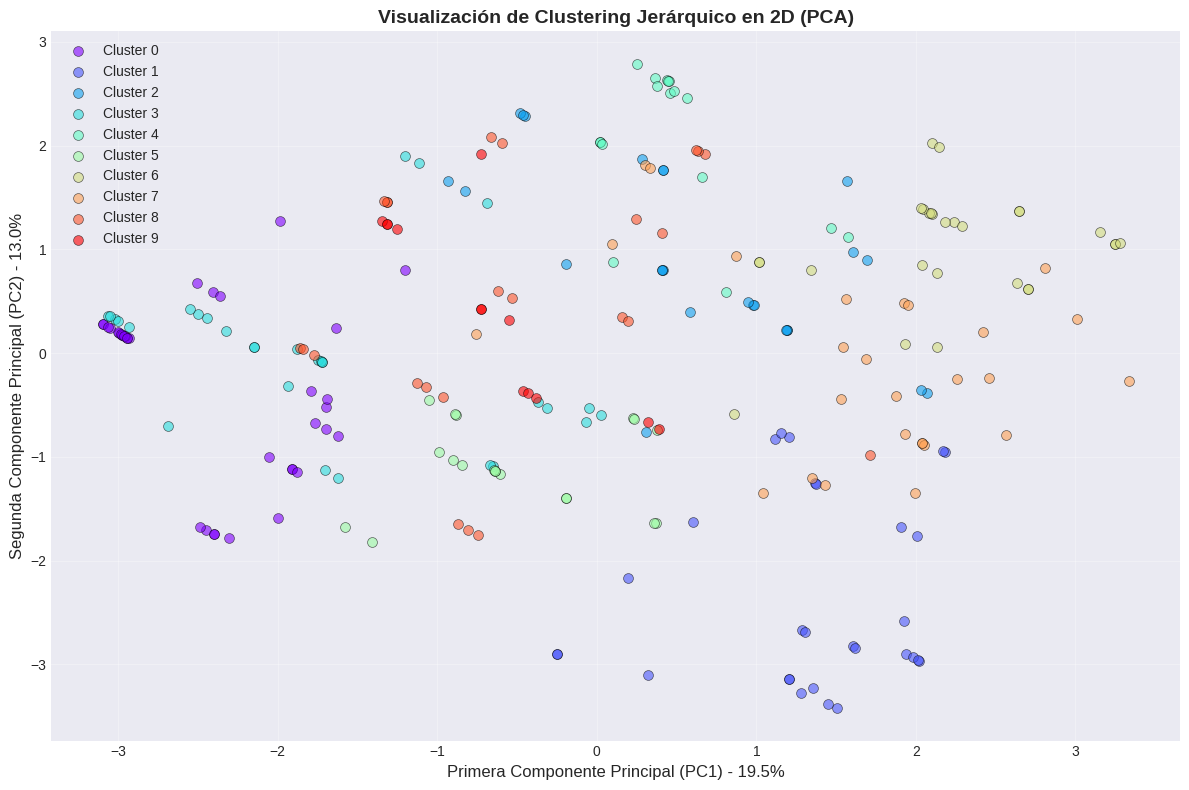

In [49]:
# ============================================================================
# 14.6. Clustering Jerárquico (Hierarchical Clustering)
# ============================================================================

print("\n" + "-"*80)
print("CLUSTERING JERÁRQUICO (AGGLOMERATIVE)")
print("-"*80)

# Usar una muestra más pequeña para el dendrograma (por rendimiento)
sample_size = min(100, len(X_clustering))
X_sample = X_clustering[:sample_size]

# Clustering jerárquico
hierarchical = AgglomerativeClustering(
    n_clusters=optimal_k,
    linkage='ward'
)

hierarchical_labels = hierarchical.fit_predict(X_clustering)

# Métricas
silhouette_hierarchical = silhouette_score(X_clustering, hierarchical_labels)

print(f"\nResultados de Clustering Jerárquico (k={optimal_k}):")
print(f"Silhouette Score: {silhouette_hierarchical:.4f}")

# Distribución de muestras
print("\nDistribución de muestras por cluster (Jerárquico):")
unique_h, counts_h = np.unique(hierarchical_labels, return_counts=True)
for cluster_id, count in zip(unique_h, counts_h):
    percentage = (count / len(hierarchical_labels)) * 100
    print(f"Cluster {cluster_id}: {count} muestras ({percentage:.2f}%)")

# Dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

print("\nGenerando dendrograma...")
linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(14, 8))
dendrogram(linkage_matrix,
           truncate_mode='lastp',
           p=30,
           leaf_font_size=10,
           show_contracted=True)
plt.xlabel('Índice de Muestra o (tamaño del cluster)', fontsize=12)
plt.ylabel('Distancia', fontsize=12)
plt.title('Dendrograma - Clustering Jerárquico', fontsize=14, fontweight='bold')
plt.axhline(y=linkage_matrix[-optimal_k, 2], color='red', linestyle='--',
            linewidth=2, label=f'Corte para {optimal_k} clusters')
plt.legend()
plt.tight_layout()
plt.show()

# Visualización con PCA
X_pca_hierarchical = pca.transform(X_clustering)

plt.figure(figsize=(12, 8))
for i in range(optimal_k):
    cluster_points = X_pca_hierarchical[hierarchical_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=[colors[i]], label=f'Cluster {i}',
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

plt.xlabel(f'Primera Componente Principal (PC1) - {pca.explained_variance_ratio_[0]*100:.1f}%',
           fontsize=12)
plt.ylabel(f'Segunda Componente Principal (PC2) - {pca.explained_variance_ratio_[1]*100:.1f}%',
           fontsize=12)
plt.title(f'Visualización de Clustering Jerárquico en 2D (PCA)',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
DBSCAN (DENSITY-BASED CLUSTERING)
--------------------------------------------------------------------------------

Resultados de DBSCAN:
Número de clusters encontrados: 1
Número de puntos de ruido: 237 (95.95%)

Distribución de muestras por cluster (DBSCAN):
Ruido: 237 muestras (95.95%)
Cluster 0: 10 muestras (4.05%)


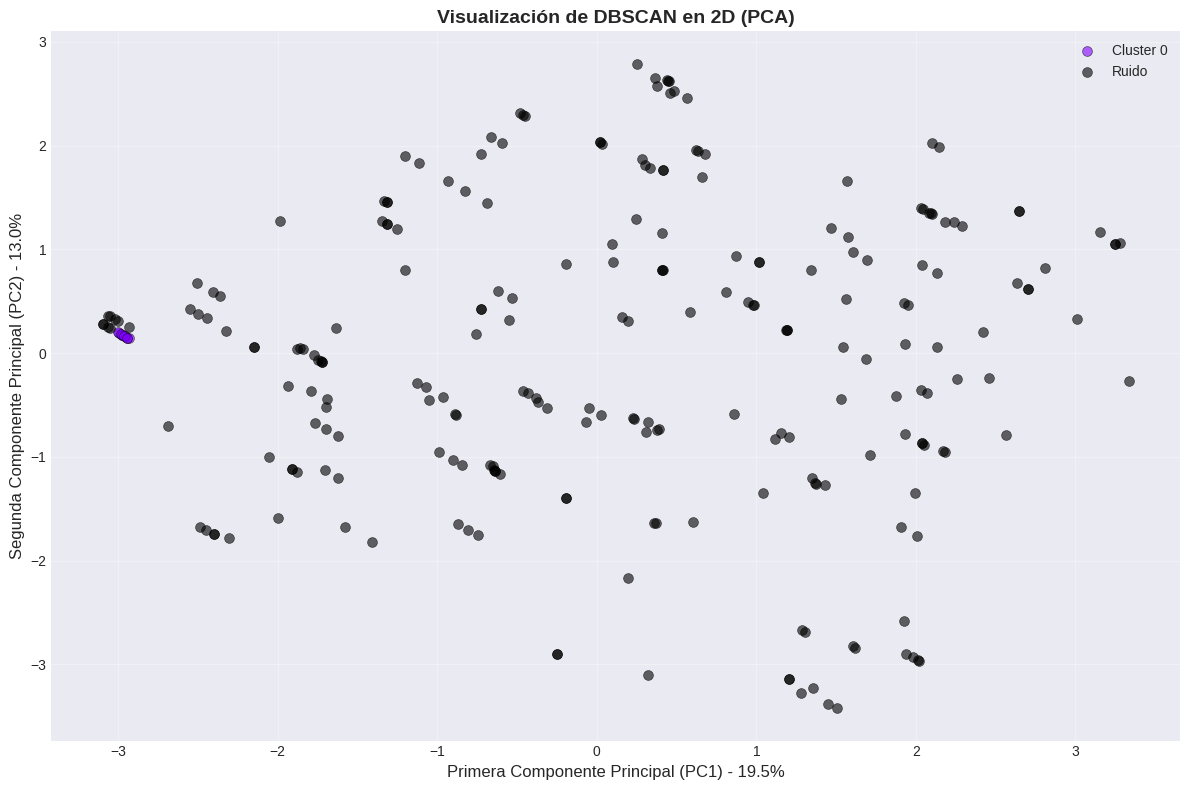

In [50]:
# ============================================================================
# 14.7. DBSCAN (Density-Based Spatial Clustering)
# ============================================================================

print("\n" + "-"*80)
print("DBSCAN (DENSITY-BASED CLUSTERING)")
print("-"*80)

# Entrenar DBSCAN
dbscan = DBSCAN(
    eps=0.5,  # Radio de vecindad
    min_samples=5  # Mínimo de muestras para formar un cluster
)

dbscan_labels = dbscan.fit_predict(X_clustering)

# Número de clusters encontrados (sin contar ruido)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nResultados de DBSCAN:")
print(f"Número de clusters encontrados: {n_clusters_dbscan}")
print(f"Número de puntos de ruido: {n_noise} ({(n_noise/len(dbscan_labels))*100:.2f}%)")

# Silhouette score (solo si hay más de 1 cluster y no todos son ruido)
if n_clusters_dbscan > 1 and n_noise < len(dbscan_labels):
    # Calcular silhouette sin considerar puntos de ruido
    mask = dbscan_labels != -1
    if sum(mask) > 0:
        silhouette_dbscan = silhouette_score(X_clustering[mask], dbscan_labels[mask])
        print(f"Silhouette Score: {silhouette_dbscan:.4f}")

# Distribución de muestras
print("\nDistribución de muestras por cluster (DBSCAN):")
unique_db, counts_db = np.unique(dbscan_labels, return_counts=True)
for cluster_id, count in zip(unique_db, counts_db):
    if cluster_id == -1:
        print(f"Ruido: {count} muestras ({(count/len(dbscan_labels))*100:.2f}%)")
    else:
        print(f"Cluster {cluster_id}: {count} muestras ({(count/len(dbscan_labels))*100:.2f}%)")

# Visualización con PCA
plt.figure(figsize=(12, 8))

# Plotear clusters
unique_labels = set(dbscan_labels)
n_clusters_plot = len(unique_labels) - (1 if -1 in unique_labels else 0)
colors_dbscan = plt.cm.rainbow(np.linspace(0, 1, n_clusters_plot + 1))

for k, col in zip(unique_labels, colors_dbscan):
    if k == -1:
        # Ruido en negro
        col = 'black'
        label = 'Ruido'
    else:
        label = f'Cluster {k}'

    class_member_mask = (dbscan_labels == k)
    xy = X_pca[class_member_mask]

    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=label,
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

plt.xlabel(f'Primera Componente Principal (PC1) - {pca.explained_variance_ratio_[0]*100:.1f}%',
           fontsize=12)
plt.ylabel(f'Segunda Componente Principal (PC2) - {pca.explained_variance_ratio_[1]*100:.1f}%',
           fontsize=12)
plt.title('Visualización de DBSCAN en 2D (PCA)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
COMPARACIÓN DE MÉTODOS DE CLUSTERING
--------------------------------------------------------------------------------

Tabla Comparativa de Métodos de Clustering:
       Método  N° Clusters  Silhouette Score
0     K-Means           10          0.175437
1  Jerárquico           10          0.168484
2      DBSCAN            1          0.000000


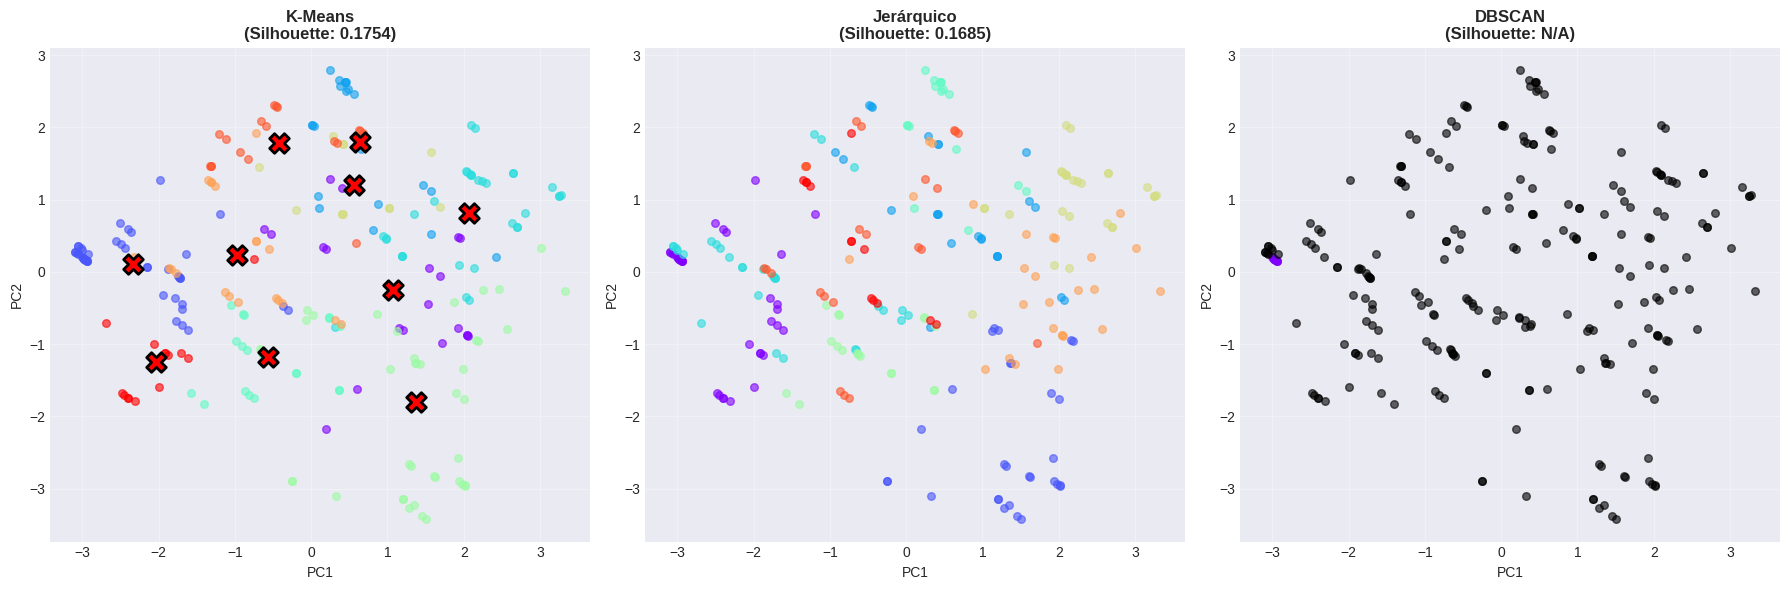

In [51]:
# ============================================================================
# 14.8. Comparación de Métodos de Clustering
# ============================================================================

print("\n" + "-"*80)
print("COMPARACIÓN DE MÉTODOS DE CLUSTERING")
print("-"*80)

# Crear tabla comparativa
clustering_comparison = pd.DataFrame({
    'Método': ['K-Means', 'Jerárquico', 'DBSCAN'],
    'N° Clusters': [optimal_k, optimal_k, n_clusters_dbscan],
    'Silhouette Score': [
        silhouette_avg,
        silhouette_hierarchical,
        silhouette_dbscan if n_clusters_dbscan > 1 else 0
    ]
})

print("\nTabla Comparativa de Métodos de Clustering:")
print(clustering_comparison)

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Means
for i in range(optimal_k):
    cluster_points = X_pca[cluster_labels == i]
    axes[0].scatter(cluster_points[:, 0], cluster_points[:, 1],
                    c=[colors[i]], alpha=0.6, s=30)
centroids_pca = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidth=2)
axes[0].set_title(f'K-Means\n(Silhouette: {silhouette_avg:.4f})',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(alpha=0.3)

# Jerárquico
for i in range(optimal_k):
    cluster_points = X_pca_hierarchical[hierarchical_labels == i]
    axes[1].scatter(cluster_points[:, 0], cluster_points[:, 1],
                    c=[colors[i]], alpha=0.6, s=30)
axes[1].set_title(f'Jerárquico\n(Silhouette: {silhouette_hierarchical:.4f})',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(alpha=0.3)

# DBSCAN
for k in set(dbscan_labels):
    if k == -1:
        col = 'black'
    else:
        col = colors_dbscan[k]

    class_member_mask = (dbscan_labels == k)
    xy = X_pca[class_member_mask]
    axes[2].scatter(xy[:, 0], xy[:, 1], c=[col], alpha=0.6, s=30)

silhouette_text = f'{silhouette_dbscan:.4f}' if n_clusters_dbscan > 1 else 'N/A'
axes[2].set_title(f'DBSCAN\n(Silhouette: {silhouette_text})',
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------
RELACIÓN ENTRE CLUSTERS Y VARIABLE OBJETIVO
--------------------------------------------------------------------------------

Distribución de Cáncer de Pulmón por Cluster (K-Means):
LUNG_CANCER             0           1
Cluster_KMeans                       
0               10.000000   90.000000
1                2.272727   97.727273
2               71.428571   28.571429
3                0.000000  100.000000
4                0.000000  100.000000
5               14.634146   85.365854
6                0.000000  100.000000
7                5.000000   95.000000
8               22.222222   77.777778
9               14.285714   85.714286


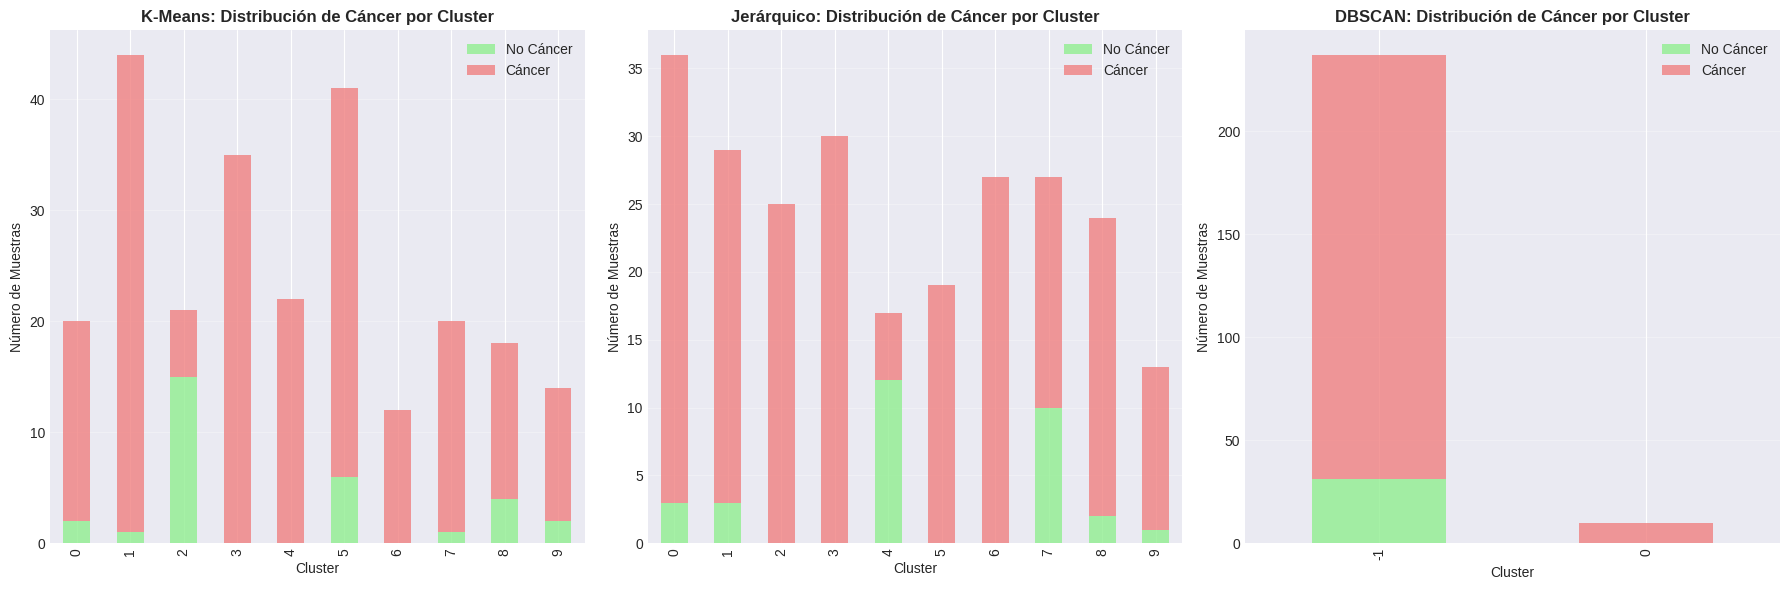


✓ ANÁLISIS DE AGRUPAMIENTO (CLUSTERING) COMPLETADO


In [53]:
# ============================================================================
# 14.9. Relación entre Clusters y Variable Objetivo
# ============================================================================

print("\n" + "-"*80)
print("RELACIÓN ENTRE CLUSTERS Y VARIABLE OBJETIVO")
print("-"*80)

# Añadir etiquetas de cluster y variable objetivo
comparison_df = pd.DataFrame({
    'Cluster_KMeans': cluster_labels,
    'Cluster_Hierarchical': hierarchical_labels,
    'Cluster_DBSCAN': dbscan_labels,
    'LUNG_CANCER': y_train
})

# Análisis para K-Means
print("\nDistribución de Cáncer de Pulmón por Cluster (K-Means):")
kmeans_cancer_dist = pd.crosstab(comparison_df['Cluster_KMeans'],
                                  comparison_df['LUNG_CANCER'],
                                  normalize='index') * 100
print(kmeans_cancer_dist)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Means
crosstab_kmeans = pd.crosstab(comparison_df['Cluster_KMeans'],
                               comparison_df['LUNG_CANCER'])
crosstab_kmeans.plot(kind='bar', stacked=True, ax=axes[0],
                     color=['lightgreen', 'lightcoral'], alpha=0.8)
axes[0].set_title('K-Means: Distribución de Cáncer por Cluster',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Número de Muestras')
axes[0].legend(['No Cáncer', 'Cáncer'])
axes[0].grid(alpha=0.3, axis='y')

# Jerárquico
crosstab_hierarchical = pd.crosstab(comparison_df['Cluster_Hierarchical'],
                                     comparison_df['LUNG_CANCER'])
crosstab_hierarchical.plot(kind='bar', stacked=True, ax=axes[1],
                           color=['lightgreen', 'lightcoral'], alpha=0.8)
axes[1].set_title('Jerárquico: Distribución de Cáncer por Cluster',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Número de Muestras')
axes[1].legend(['No Cáncer', 'Cáncer'])
axes[1].grid(alpha=0.3, axis='y')

# DBSCAN
crosstab_dbscan = pd.crosstab(comparison_df['Cluster_DBSCAN'],
                               comparison_df['LUNG_CANCER'])
crosstab_dbscan.plot(kind='bar', stacked=True, ax=axes[2],
                     color=['lightgreen', 'lightcoral'], alpha=0.8)
axes[2].set_title('DBSCAN: Distribución de Cáncer por Cluster',
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Número de Muestras')
axes[2].legend(['No Cáncer', 'Cáncer'])
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ ANÁLISIS DE AGRUPAMIENTO (CLUSTERING) COMPLETADO")
print("="*80)